In [262]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, display
import io
from PIL import Image

# Probabilities for stochastic movement
P_MAIN = 0.8
P_SIDE = 0.1

In [263]:
class GridWorld:
    def __init__(self, size=5, goals=[(4, 4)], obstacles=None,
                 max_steps=50, dynamic_elements=False,
                 obstacle_penalty=-5.0, step_penalty=-1.0, goal_reward=1.0,
                 collision_extra_penalty=-2.0):
        self.size = size
        self.goals = goals
        self.obstacle_penalty = obstacle_penalty
        self.step_penalty = step_penalty
        self.goal_reward = goal_reward
        self.collision_extra_penalty = collision_extra_penalty
        if obstacles is None:
            obstacles = []
        self.obstacles = obstacles
        self.max_steps = max_steps
        self.dynamic_elements = dynamic_elements
        self.state_space = [(r, c) for r in range(size) for c in range(size)]
        self.action_space = 4
        self.reset()

    def reset(self):
        self.agent_pos = [0, 0]
        self.steps = 0
        self.collision_count = 0  # Compteur de collisions
        return self.get_state()

    def get_state(self):
        return tuple(self.agent_pos)

    def _get_next_pos(self, x, y, action):
        new_x, new_y = x, y
        if action == 0 and x > 0: new_x -= 1         # up
        elif action == 1 and x < self.size - 1: new_x += 1  # down
        elif action == 2 and y > 0: new_y -= 1       # left
        elif action == 3 and y < self.size - 1: new_y += 1  # right
        return [new_x, new_y]

    def _move_dynamic_elements(self):
        if self.dynamic_elements:
            self.goals = [(
                random.randint(0, self.size - 1),
                random.randint(0, self.size - 1)
            ) for _ in self.goals]
            self.obstacles = [(
                random.randint(0, self.size - 1),
                random.randint(0, self.size - 1)
            ) for _ in self.obstacles]
            self.goals = [g for g in self.goals if g != tuple(self.agent_pos)]
            self.obstacles = [o for o in self.obstacles if o != tuple(self.agent_pos)]

    def step(self, action):
        x, y = self.agent_pos

        # Add stochasticity
        if action in [0, 1]:
            move_choices = [action, 2, 3]
        else:
            move_choices = [action, 0, 1]
        effective_action = np.random.choice(move_choices, p=[P_MAIN, P_SIDE, P_SIDE])
        new_pos = self._get_next_pos(x, y, effective_action)

        # Check if hitting obstacle
        if tuple(new_pos) in self.obstacles:
            # stays in place, obstacle penalty
            self.collision_count += 1
            # Pénalité de base + pénalité supplémentaire cumulative
            reward = self.obstacle_penalty + (self.collision_extra_penalty * self.collision_count)
        else:
            # valid move
            self.agent_pos = new_pos
            reward = self.step_penalty

        self.steps += 1
        self._move_dynamic_elements()

        # Check goal
        if tuple(self.agent_pos) in self.goals:
            reward = self.goal_reward
            done = True
        else:
            done = self.steps >= self.max_steps

        return self.get_state(), reward, done

    def render_to_array(self):
        """Render the environment to a numpy array for video creation"""
        fig, ax = plt.subplots(figsize=(5, 5))
        grid = np.zeros((self.size, self.size))
        for ox, oy in self.obstacles:
            grid[ox, oy] = 3  # obstacles
        for gx, gy in self.goals:
            grid[gx, gy] = 2  # goals
        
        cmap = ListedColormap(["white", "gray", "red", "black"])
        ax.imshow(grid, cmap=cmap, origin="upper", vmin=0, vmax=3)
        ax.scatter(self.agent_pos[1], self.agent_pos[0], c='green', s=300, edgecolors='black', linewidths=2)
        ax.set_xticks(range(self.size))
        ax.set_yticks(range(self.size))
        ax.grid(True, alpha=0.3)
        # Afficher aussi le nombre de collisions
        ax.set_title(f"Step: {self.steps} | Position: {self.agent_pos} | Collisions: {self.collision_count}", 
                    fontsize=12, fontweight='bold')
        
        # Convert to array (compatible with newer matplotlib versions)
        fig.canvas.draw()
        # Use buffer_rgba() instead of tostring_rgb()
        buf = fig.canvas.buffer_rgba()
        img = np.asarray(buf)
        # Convert RGBA to RGB
        img = img[:, :, :3]
        plt.close(fig)
        return img

In [264]:
def q_learning_with_video(env, episodes=5000, alpha=0.1, gamma=0.95,
                         eps_start=1.0, eps_end=0.05, eps_decay_episodes=None,
                         record_episodes=None):
    """
    Q-learning training loop with video recording of selected episodes.
    """
    state_count = env.size * env.size
    Q = np.zeros((state_count, env.action_space))
    rewards = np.zeros(episodes)
    successes = np.zeros(episodes, dtype=int)
    
    episode_videos = {}  # Store frames for selected episodes

    if eps_decay_episodes is None:
        eps_decay_episodes = episodes
    if record_episodes is None:
        record_episodes = []

    for ep in range(episodes):
        epsilon = max(eps_end, eps_start - (eps_start - eps_end) * (ep / eps_decay_episodes))
        state = env.reset()
        done = False
        total_reward = 0
        
        # Record frames if this episode should be recorded
        record = ep in record_episodes
        frames = []
        
        if record:
            print(f"Recording episode {ep}")
            frames.append(env.render_to_array())

        while not done:
            s_index = state[0] * env.size + state[1]
            if random.random() < epsilon:
                action = random.randint(0, env.action_space - 1)
            else:
                action = int(np.argmax(Q[s_index, :]))

            next_state, reward, done = env.step(action)
            ns_index = next_state[0] * env.size + next_state[1]

            # Q-learning update
            old = Q[s_index, action]
            Q[s_index, action] = (1 - alpha) * old + alpha * (reward + gamma * np.max(Q[ns_index, :]))

            state = next_state
            total_reward += reward
            
            if record:
                frames.append(env.render_to_array())

        rewards[ep] = total_reward
        successes[ep] = 1 if tuple(env.agent_pos) in env.goals else 0
        
        if record:
            episode_videos[ep] = frames

    return Q, rewards, successes, episode_videos


def create_video_from_frames(frames, filename='episode.gif', fps=5):
    """Create a GIF from frames"""
    if len(frames) == 0:
        print("No frames to create video")
        return
    
    images = [Image.fromarray(frame) for frame in frames]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000//fps,
        loop=0
    )
    print(f"Video saved as {filename}")
    return filename

In [265]:
def moving_average(x, w):
    """Calculate moving average for smoothing"""
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w) / w, mode='valid')

### Configuration et Entraînement avec Goal Fixe

In [266]:
# Configuration
random.seed(0)
np.random.seed(0)

GRID_SIZE = 7
EPISODES = 1000
ALPHA = 0.1
GAMMA = 0.95
EPS_START = 1.0
EPS_END = 0.05
MAX_STEPS = 100

# Create environment with fixed goal
goal = (GRID_SIZE - 1, GRID_SIZE - 1)
rng = random.Random(42)
num_obstacles = GRID_SIZE
obstacles = []
while len(obstacles) < num_obstacles:
    ox = rng.randint(0, GRID_SIZE - 1)
    oy = rng.randint(0, GRID_SIZE - 1)
    pos = (ox, oy)
    if pos != (0, 0) and pos != goal and pos not in obstacles:
        obstacles.append(pos)

env_fixed = GridWorld(
    size=GRID_SIZE, 
    goals=[goal], 
    obstacles=obstacles,
    max_steps=MAX_STEPS, 
    dynamic_elements=False,
    obstacle_penalty=-5.0, 
    step_penalty=-0.1, 
    goal_reward=10.0
)

print(f"Environment {GRID_SIZE}x{GRID_SIZE}")
print(f"Goal: {goal}")
print(f"Obstacles: {obstacles}")
print(f"Episodes: {EPISODES}")

Environment 7x7
Goal: (6, 6)
Obstacles: [(5, 0), (0, 5), (2, 1), (1, 1), (5, 5), (4, 0), (4, 3)]
Episodes: 1000


In [267]:
# Entraînement avec enregistrement vidéo
# On enregistre les épisodes 0, 500, et 999
record_episodes = [0, 500, 999]

Q_fixed, rewards_fixed, successes_fixed, videos_fixed = q_learning_with_video(
    env_fixed,
    episodes=EPISODES,
    alpha=ALPHA,
    gamma=GAMMA,
    eps_start=EPS_START,
    eps_end=EPS_END,
    record_episodes=record_episodes
)

print(f"\nEntraînement terminé!")
print(f"Taux de réussite final (100 derniers épisodes): {np.mean(successes_fixed[-100:]):.2%}")

Recording episode 0
Recording episode 500
Recording episode 500
Recording episode 999
Recording episode 999

Entraînement terminé!
Taux de réussite final (100 derniers épisodes): 100.00%

Entraînement terminé!
Taux de réussite final (100 derniers épisodes): 100.00%


In [268]:
# Créer et sauvegarder les vidéos
for ep_num in record_episodes:
    if ep_num in videos_fixed:
        filename = f"episode_{ep_num}_fixed_goal.gif"
        create_video_from_frames(videos_fixed[ep_num], filename, fps=5)
        print(f"Épisode {ep_num}: {len(videos_fixed[ep_num])} frames")

Video saved as episode_0_fixed_goal.gif
Épisode 0: 101 frames
Video saved as episode_500_fixed_goal.gif
Épisode 500: 38 frames
Video saved as episode_500_fixed_goal.gif
Épisode 500: 38 frames
Video saved as episode_999_fixed_goal.gif
Épisode 999: 30 frames
Video saved as episode_999_fixed_goal.gif
Épisode 999: 30 frames


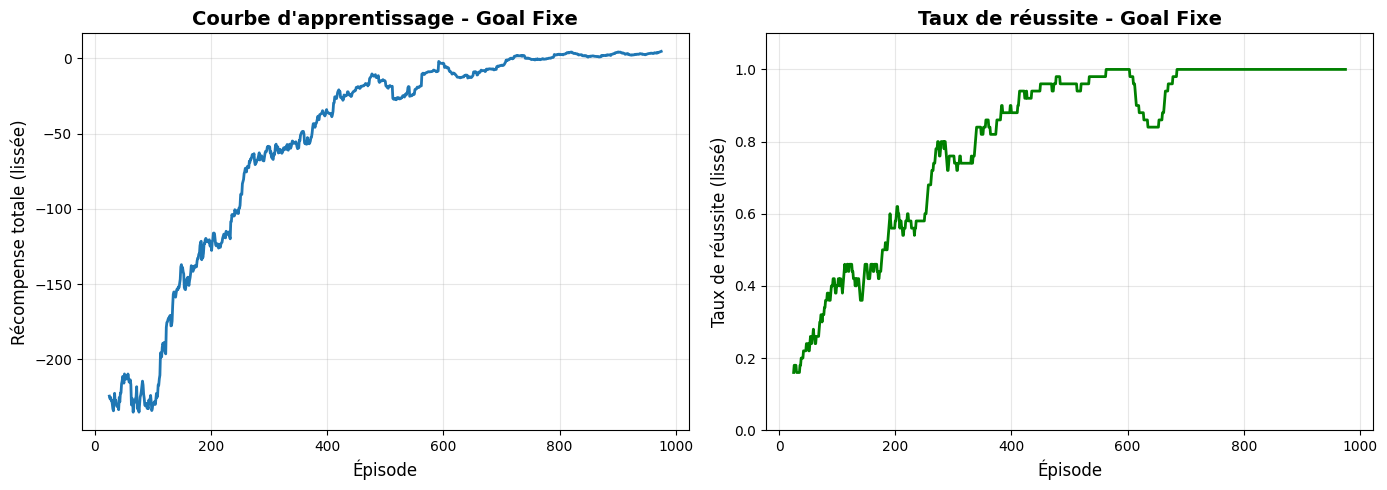

In [269]:
# Visualisation des courbes d'apprentissage
plt.figure(figsize=(14, 5))

# Subplot 1: Récompenses
plt.subplot(1, 2, 1)
window = 50
smoothed_rewards = moving_average(rewards_fixed, window)
plt.plot(np.arange(len(smoothed_rewards)) + window // 2, smoothed_rewards, linewidth=2)
plt.xlabel("Épisode", fontsize=12)
plt.ylabel("Récompense totale (lissée)", fontsize=12)
plt.title("Courbe d'apprentissage - Goal Fixe", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Subplot 2: Taux de réussite
plt.subplot(1, 2, 2)
smoothed_success = moving_average(successes_fixed.astype(float), window)
plt.plot(np.arange(len(smoothed_success)) + window // 2, smoothed_success, 
         linewidth=2, color='green')
plt.xlabel("Épisode", fontsize=12)
plt.ylabel("Taux de réussite (lissé)", fontsize=12)
plt.title("Taux de réussite - Goal Fixe", fontsize=14, fontweight='bold')
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Partie 2: Environnement avec Goal Mobile (Non-Stationnaire)


In [270]:
class GridWorldMovingGoal(GridWorld):
    """GridWorld avec un goal qui se déplace périodiquement"""
    
    def __init__(self, size=5, initial_goal=(4, 4), obstacles=None,
                 max_steps=50, goal_change_frequency=100,
                 obstacle_penalty=-5.0, step_penalty=-1.0, goal_reward=10.0,
                 collision_extra_penalty=-2.0):
        self.goal_change_frequency = goal_change_frequency
        self.initial_goal = initial_goal
        self.episode_count = 0
        super().__init__(size, goals=[initial_goal], obstacles=obstacles,
                        max_steps=max_steps, dynamic_elements=False,
                        obstacle_penalty=obstacle_penalty,
                        step_penalty=step_penalty,
                        goal_reward=goal_reward,
                        collision_extra_penalty=collision_extra_penalty)
    
    def reset(self):
        """Reset et change le goal périodiquement"""
        self.agent_pos = [0, 0]
        self.steps = 0
        self.collision_count = 0  # Réinitialiser le compteur de collisions
        self.episode_count += 1
        
        # Change goal every goal_change_frequency episodes
        if self.episode_count % self.goal_change_frequency == 0:
            # Generate new random goal position
            new_goal = None
            while new_goal is None or new_goal in self.obstacles or new_goal == (0, 0):
                new_goal = (
                    random.randint(0, self.size - 1),
                    random.randint(0, self.size - 1)
                )
            self.goals = [new_goal]
            print(f"Episode {self.episode_count}: Goal déplacé vers {new_goal}")
        
        return self.get_state()

### Configuration et Entraînement avec Goal Mobile

In [271]:
# Configuration pour goal mobile
random.seed(42)
np.random.seed(42)

EPISODES_MOVING = 1500
GOAL_CHANGE_FREQ = 300  # Le goal change tous les 300 épisodes

# Créer l'environnement avec goal mobile
env_moving = GridWorldMovingGoal(
    size=GRID_SIZE,
    initial_goal=goal,
    obstacles=obstacles,
    max_steps=MAX_STEPS,
    goal_change_frequency=GOAL_CHANGE_FREQ,
    obstacle_penalty=-5.0,
    step_penalty=-0.1,
    goal_reward=10.0
)

print(f"Environment {GRID_SIZE}x{GRID_SIZE} avec Goal Mobile")
print(f"Goal initial: {goal}")
print(f"Obstacles: {obstacles}")
print(f"Episodes: {EPISODES_MOVING}")
print(f"Fréquence de changement de goal: tous les {GOAL_CHANGE_FREQ} épisodes")

Environment 7x7 avec Goal Mobile
Goal initial: (6, 6)
Obstacles: [(5, 0), (0, 5), (2, 1), (1, 1), (5, 5), (4, 0), (4, 3)]
Episodes: 1500
Fréquence de changement de goal: tous les 300 épisodes


In [272]:
# Entraînement avec goal mobile
# Enregistrer les épisodes 0, 300, 600, 900, 1200, et 1499
record_episodes_moving = [0, 300, 600, 900, 1200, 1499]

Q_moving, rewards_moving, successes_moving, videos_moving = q_learning_with_video(
    env_moving,
    episodes=EPISODES_MOVING,
    alpha=ALPHA,
    gamma=GAMMA,
    eps_start=EPS_START,
    eps_end=EPS_END,
    record_episodes=record_episodes_moving
)

print(f"\nEntraînement terminé!")
print(f"Taux de réussite final (100 derniers épisodes): {np.mean(successes_moving[-100:]):.2%}")

Recording episode 0
Episode 300: Goal déplacé vers (3, 1)
Recording episode 300
Episode 300: Goal déplacé vers (3, 1)
Recording episode 300
Episode 600: Goal déplacé vers (3, 5)
Recording episode 600
Episode 600: Goal déplacé vers (3, 5)
Recording episode 600
Episode 900: Goal déplacé vers (3, 0)
Recording episode 900
Episode 900: Goal déplacé vers (3, 0)
Recording episode 900
Episode 1200: Goal déplacé vers (1, 3)
Recording episode 1200
Episode 1200: Goal déplacé vers (1, 3)
Recording episode 1200
Episode 1500: Goal déplacé vers (3, 2)
Recording episode 1499
Episode 1500: Goal déplacé vers (3, 2)
Recording episode 1499

Entraînement terminé!
Taux de réussite final (100 derniers épisodes): 99.00%

Entraînement terminé!
Taux de réussite final (100 derniers épisodes): 99.00%


In [273]:
# Créer et sauvegarder les vidéos pour goal mobile
for ep_num in record_episodes_moving:
    if ep_num in videos_moving:
        filename = f"episode_{ep_num}_moving_goal.gif"
        create_video_from_frames(videos_moving[ep_num], filename, fps=5)
        print(f"Épisode {ep_num}: {len(videos_moving[ep_num])} frames")

Video saved as episode_0_moving_goal.gif
Épisode 0: 101 frames
Video saved as episode_300_moving_goal.gif
Épisode 300: 77 frames
Video saved as episode_300_moving_goal.gif
Épisode 300: 77 frames
Video saved as episode_600_moving_goal.gif
Épisode 600: 66 frames
Video saved as episode_600_moving_goal.gif
Épisode 600: 66 frames
Video saved as episode_900_moving_goal.gif
Épisode 900: 101 frames
Video saved as episode_900_moving_goal.gif
Épisode 900: 101 frames
Video saved as episode_1200_moving_goal.gif
Épisode 1200: 18 frames
Video saved as episode_1200_moving_goal.gif
Épisode 1200: 18 frames
Video saved as episode_1499_moving_goal.gif
Épisode 1499: 56 frames
Video saved as episode_1499_moving_goal.gif
Épisode 1499: 56 frames


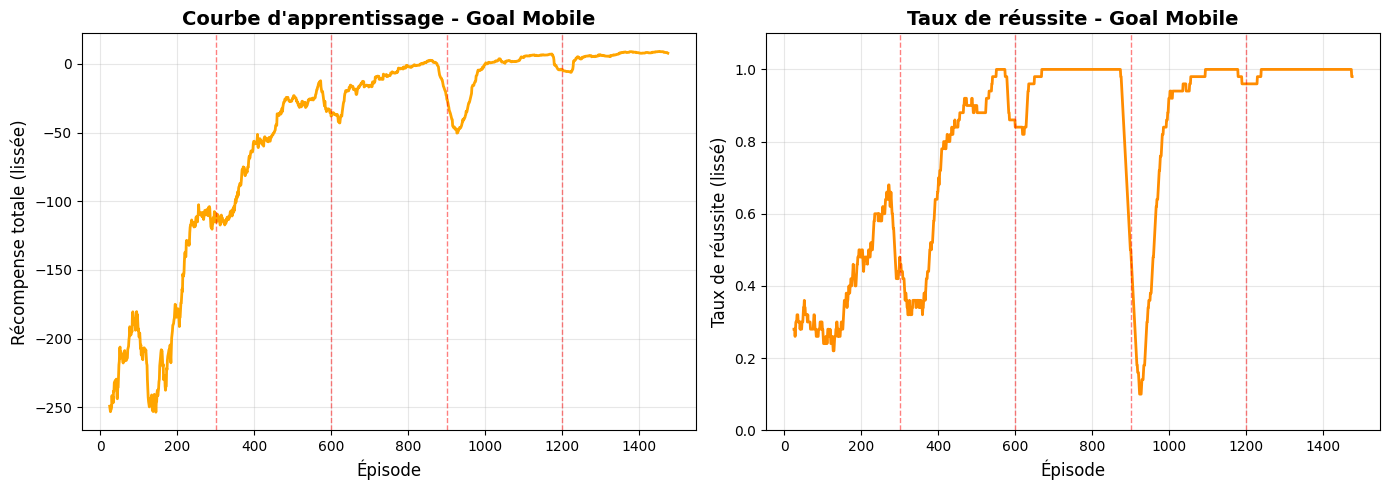

In [274]:
# Visualisation des courbes d'apprentissage pour goal mobile
plt.figure(figsize=(14, 5))

# Subplot 1: Récompenses
plt.subplot(1, 2, 1)
window = 50
smoothed_rewards_moving = moving_average(rewards_moving, window)
plt.plot(np.arange(len(smoothed_rewards_moving)) + window // 2, smoothed_rewards_moving, 
         linewidth=2, color='orange')
plt.xlabel("Épisode", fontsize=12)
plt.ylabel("Récompense totale (lissée)", fontsize=12)
plt.title("Courbe d'apprentissage - Goal Mobile", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Marquer les changements de goal
for change_ep in range(GOAL_CHANGE_FREQ, EPISODES_MOVING, GOAL_CHANGE_FREQ):
    plt.axvline(x=change_ep, color='red', linestyle='--', alpha=0.5, linewidth=1)

# Subplot 2: Taux de réussite
plt.subplot(1, 2, 2)
smoothed_success_moving = moving_average(successes_moving.astype(float), window)
plt.plot(np.arange(len(smoothed_success_moving)) + window // 2, smoothed_success_moving, 
         linewidth=2, color='darkorange')
plt.xlabel("Épisode", fontsize=12)
plt.ylabel("Taux de réussite (lissé)", fontsize=12)
plt.title("Taux de réussite - Goal Mobile", fontsize=14, fontweight='bold')
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3)

# Marquer les changements de goal
for change_ep in range(GOAL_CHANGE_FREQ, EPISODES_MOVING, GOAL_CHANGE_FREQ):
    plt.axvline(x=change_ep, color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

### Comparaison: Goal Fixe vs Goal Mobile

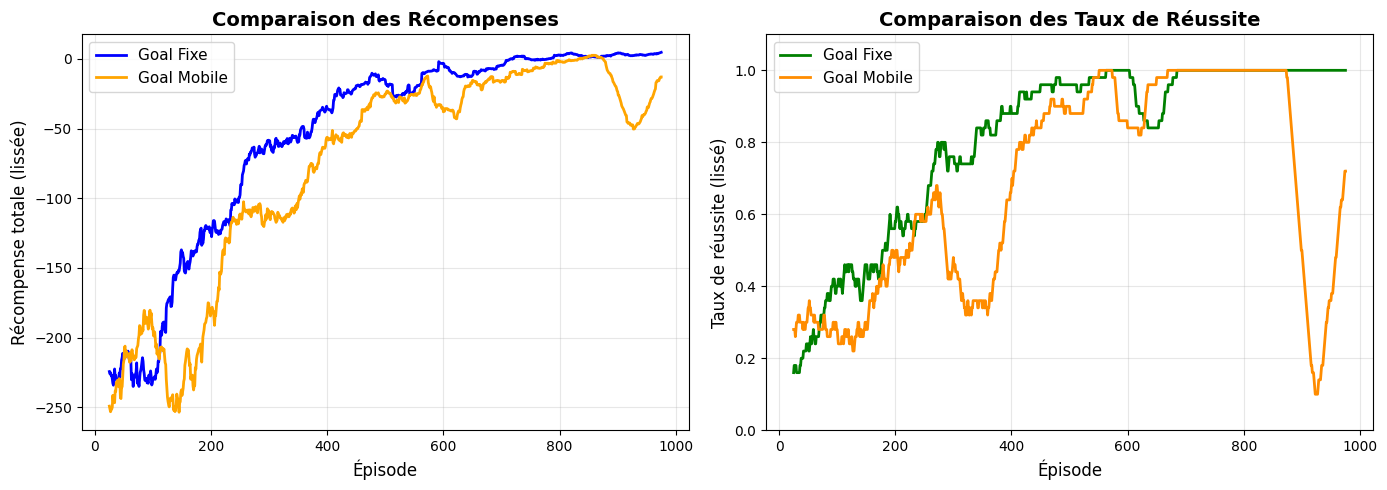


STATISTIQUES FINALES (100 derniers épisodes)
Goal Fixe:
  - Taux de réussite: 100.00%
  - Récompense moyenne: 3.45

Goal Mobile:
  - Taux de réussite: 99.00%
  - Récompense moyenne: 7.89


In [275]:
# Comparaison des deux approches
plt.figure(figsize=(14, 5))

# Récompenses comparées
plt.subplot(1, 2, 1)
window = 50
smoothed_fixed = moving_average(rewards_fixed, window)
smoothed_moving = moving_average(rewards_moving[:len(rewards_fixed)], window)

plt.plot(np.arange(len(smoothed_fixed)) + window // 2, smoothed_fixed, 
         label='Goal Fixe', linewidth=2, color='blue')
plt.plot(np.arange(len(smoothed_moving)) + window // 2, smoothed_moving, 
         label='Goal Mobile', linewidth=2, color='orange')
plt.xlabel("Épisode", fontsize=12)
plt.ylabel("Récompense totale (lissée)", fontsize=12)
plt.title("Comparaison des Récompenses", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Taux de réussite comparés
plt.subplot(1, 2, 2)
smoothed_success_fixed = moving_average(successes_fixed.astype(float), window)
smoothed_success_moving = moving_average(successes_moving[:len(successes_fixed)].astype(float), window)

plt.plot(np.arange(len(smoothed_success_fixed)) + window // 2, smoothed_success_fixed, 
         label='Goal Fixe', linewidth=2, color='green')
plt.plot(np.arange(len(smoothed_success_moving)) + window // 2, smoothed_success_moving, 
         label='Goal Mobile', linewidth=2, color='darkorange')
plt.xlabel("Épisode", fontsize=12)
plt.ylabel("Taux de réussite (lissé)", fontsize=12)
plt.title("Comparaison des Taux de Réussite", fontsize=14, fontweight='bold')
plt.ylim(0, 1.1)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques finales
print("\n" + "="*60)
print("STATISTIQUES FINALES (100 derniers épisodes)")
print("="*60)
print(f"Goal Fixe:")
print(f"  - Taux de réussite: {np.mean(successes_fixed[-100:]):.2%}")
print(f"  - Récompense moyenne: {np.mean(rewards_fixed[-100:]):.2f}")
print(f"\nGoal Mobile:")
print(f"  - Taux de réussite: {np.mean(successes_moving[-100:]):.2%}")
print(f"  - Récompense moyenne: {np.mean(rewards_moving[-100:]):.2f}")
print("="*60)

### Analyses Avancées - Comparaison Détaillée

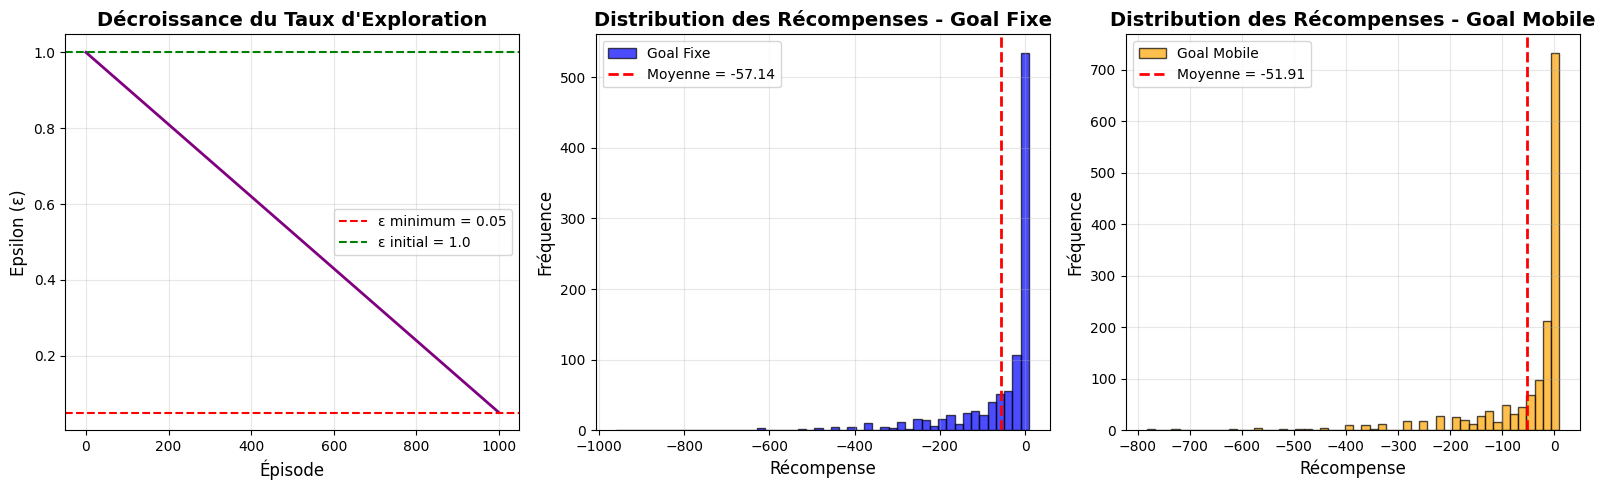

In [276]:
# 1. Évolution de l'epsilon (exploration vs exploitation)
plt.figure(figsize=(16, 5))

# Subplot 1: Décroissance d'epsilon
plt.subplot(1, 3, 1)
eps_decay_episodes = EPISODES
epsilon_values = [max(EPS_END, EPS_START - (EPS_START - EPS_END) * (ep / eps_decay_episodes)) 
                  for ep in range(EPISODES)]
plt.plot(epsilon_values, linewidth=2, color='purple')
plt.xlabel("Épisode", fontsize=12)
plt.ylabel("Epsilon (ε)", fontsize=12)
plt.title("Décroissance du Taux d'Exploration", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=EPS_END, color='r', linestyle='--', label=f'ε minimum = {EPS_END}')
plt.axhline(y=EPS_START, color='g', linestyle='--', label=f'ε initial = {EPS_START}')
plt.legend()

# Subplot 2: Distribution des récompenses (Goal Fixe)
plt.subplot(1, 3, 2)
plt.hist(rewards_fixed, bins=50, alpha=0.7, color='blue', edgecolor='black', label='Goal Fixe')
plt.xlabel("Récompense", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.title("Distribution des Récompenses - Goal Fixe", fontsize=14, fontweight='bold')
plt.axvline(x=np.mean(rewards_fixed), color='red', linestyle='--', 
           linewidth=2, label=f'Moyenne = {np.mean(rewards_fixed):.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Distribution des récompenses (Goal Mobile)
plt.subplot(1, 3, 3)
plt.hist(rewards_moving, bins=50, alpha=0.7, color='orange', edgecolor='black', label='Goal Mobile')
plt.xlabel("Récompense", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.title("Distribution des Récompenses - Goal Mobile", fontsize=14, fontweight='bold')
plt.axvline(x=np.mean(rewards_moving), color='red', linestyle='--', 
           linewidth=2, label=f'Moyenne = {np.mean(rewards_moving):.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

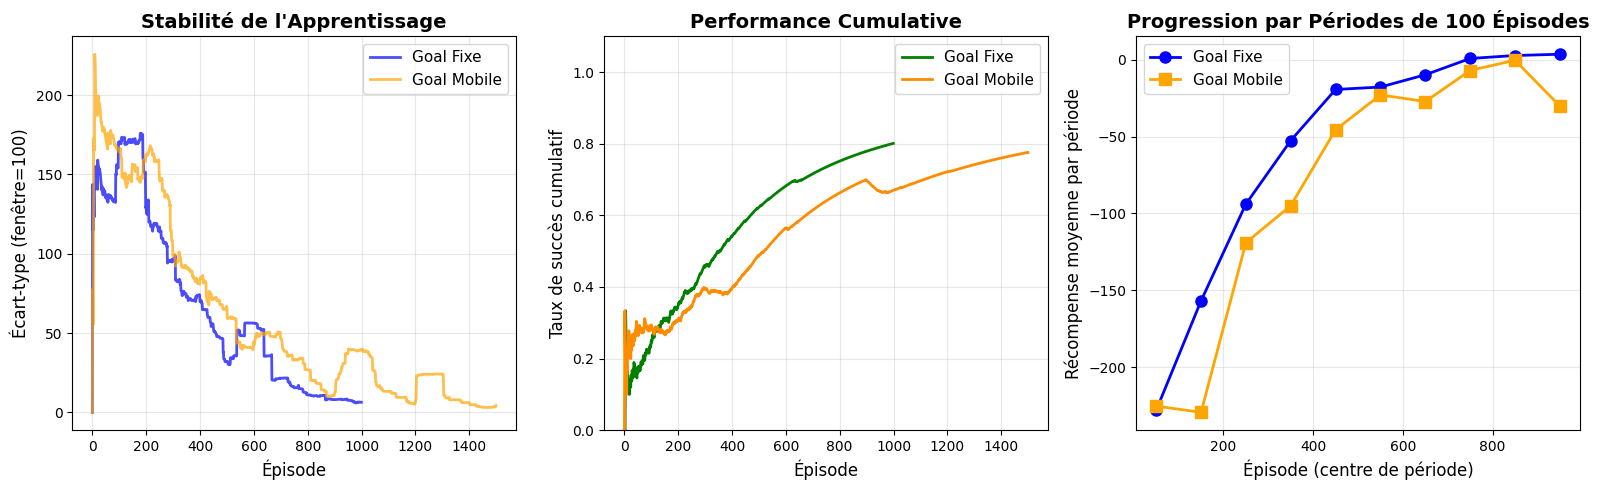

In [277]:
# 2. Analyse de la variance et stabilité
plt.figure(figsize=(16, 5))

# Subplot 1: Écart-type mobile (stabilité de l'apprentissage)
plt.subplot(1, 3, 1)
window_std = 100
std_fixed = [np.std(rewards_fixed[max(0, i-window_std):i+1]) for i in range(len(rewards_fixed))]
std_moving = [np.std(rewards_moving[max(0, i-window_std):i+1]) for i in range(len(rewards_moving))]

plt.plot(std_fixed, label='Goal Fixe', linewidth=2, color='blue', alpha=0.7)
plt.plot(std_moving, label='Goal Mobile', linewidth=2, color='orange', alpha=0.7)
plt.xlabel("Épisode", fontsize=12)
plt.ylabel("Écart-type (fenêtre=100)", fontsize=12)
plt.title("Stabilité de l'Apprentissage", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Subplot 2: Taux de succès cumulatif
plt.subplot(1, 3, 2)
cumulative_success_fixed = np.cumsum(successes_fixed) / (np.arange(len(successes_fixed)) + 1)
cumulative_success_moving = np.cumsum(successes_moving) / (np.arange(len(successes_moving)) + 1)

plt.plot(cumulative_success_fixed, label='Goal Fixe', linewidth=2, color='green')
plt.plot(cumulative_success_moving, label='Goal Mobile', linewidth=2, color='darkorange')
plt.xlabel("Épisode", fontsize=12)
plt.ylabel("Taux de succès cumulatif", fontsize=12)
plt.title("Performance Cumulative", fontsize=14, fontweight='bold')
plt.ylim(0, 1.1)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Subplot 3: Amélioration par période (100 épisodes)
plt.subplot(1, 3, 3)
period_size = 100
periods = len(rewards_fixed) // period_size
mean_rewards_fixed_per_period = [np.mean(rewards_fixed[i*period_size:(i+1)*period_size]) 
                                  for i in range(periods)]
mean_rewards_moving_per_period = [np.mean(rewards_moving[i*period_size:(i+1)*period_size]) 
                                   for i in range(periods)]

x_periods = np.arange(periods) * period_size + period_size // 2
plt.plot(x_periods, mean_rewards_fixed_per_period, marker='o', markersize=8, 
         linewidth=2, color='blue', label='Goal Fixe')
plt.plot(x_periods, mean_rewards_moving_per_period, marker='s', markersize=8, 
         linewidth=2, color='orange', label='Goal Mobile')
plt.xlabel("Épisode (centre de période)", fontsize=12)
plt.ylabel("Récompense moyenne par période", fontsize=12)
plt.title("Progression par Périodes de 100 Épisodes", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\Rog strix Scar\AppData\Local\Temp\ipykernel_7252\2745641754.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = plt.boxplot(data_rewards, labels=['Goal Fixe', 'Goal Mobile'],


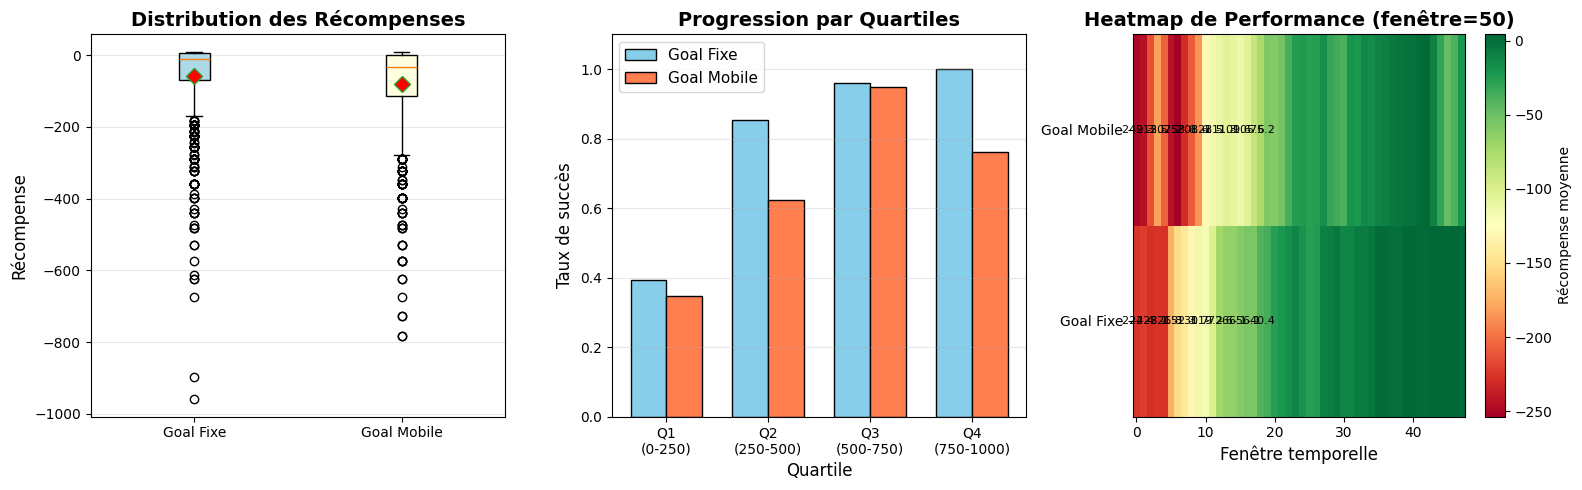

In [278]:
# 3. Box plots et comparaisons statistiques
plt.figure(figsize=(16, 5))

# Subplot 1: Box plot des récompenses
plt.subplot(1, 3, 1)
data_rewards = [rewards_fixed, rewards_moving[:len(rewards_fixed)]]
bp1 = plt.boxplot(data_rewards, labels=['Goal Fixe', 'Goal Mobile'], 
                  patch_artist=True, showmeans=True,
                  meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
colors = ['lightblue', 'lightyellow']
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("Récompense", fontsize=12)
plt.title("Distribution des Récompenses", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Subplot 2: Taux de succès par quartile
plt.subplot(1, 3, 2)
quartiles = 4
episodes_per_quartile = len(rewards_fixed) // quartiles
success_rate_fixed_q = [np.mean(successes_fixed[i*episodes_per_quartile:(i+1)*episodes_per_quartile]) 
                        for i in range(quartiles)]
success_rate_moving_q = [np.mean(successes_moving[i*episodes_per_quartile:(i+1)*episodes_per_quartile]) 
                         for i in range(quartiles)]

x_q = np.arange(quartiles)
width = 0.35
plt.bar(x_q - width/2, success_rate_fixed_q, width, label='Goal Fixe', 
        color='skyblue', edgecolor='black')
plt.bar(x_q + width/2, success_rate_moving_q, width, label='Goal Mobile', 
        color='coral', edgecolor='black')
plt.xlabel("Quartile", fontsize=12)
plt.ylabel("Taux de succès", fontsize=12)
plt.title("Progression par Quartiles", fontsize=14, fontweight='bold')
plt.xticks(x_q, [f'Q{i+1}\n({i*episodes_per_quartile}-{(i+1)*episodes_per_quartile})' 
                 for i in range(quartiles)])
plt.ylim(0, 1.1)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# Subplot 3: Heatmap de performance (récompense moyenne sur fenêtres glissantes)
plt.subplot(1, 3, 3)
window_heat = 50
step_heat = 20
num_windows = (len(rewards_fixed) - window_heat) // step_heat

heatmap_data = []
for i in range(0, len(rewards_fixed) - window_heat, step_heat):
    fixed_mean = np.mean(rewards_fixed[i:i+window_heat])
    moving_mean = np.mean(rewards_moving[i:i+window_heat])
    heatmap_data.append([fixed_mean, moving_mean])

heatmap_data = np.array(heatmap_data).T
im = plt.imshow(heatmap_data, aspect='auto', cmap='RdYlGn', origin='lower')
plt.colorbar(im, label='Récompense moyenne')
plt.yticks([0, 1], ['Goal Fixe', 'Goal Mobile'])
plt.xlabel("Fenêtre temporelle", fontsize=12)
plt.title(f"Heatmap de Performance (fenêtre={window_heat})", fontsize=14, fontweight='bold')

# Ajouter les valeurs dans les cellules
for i in range(heatmap_data.shape[0]):
    for j in range(min(20, heatmap_data.shape[1])):  # Limiter pour la lisibilité
        if j % 2 == 0:  # Afficher une valeur sur deux
            text = plt.text(j, i, f'{heatmap_data[i, j]:.1f}',
                           ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()

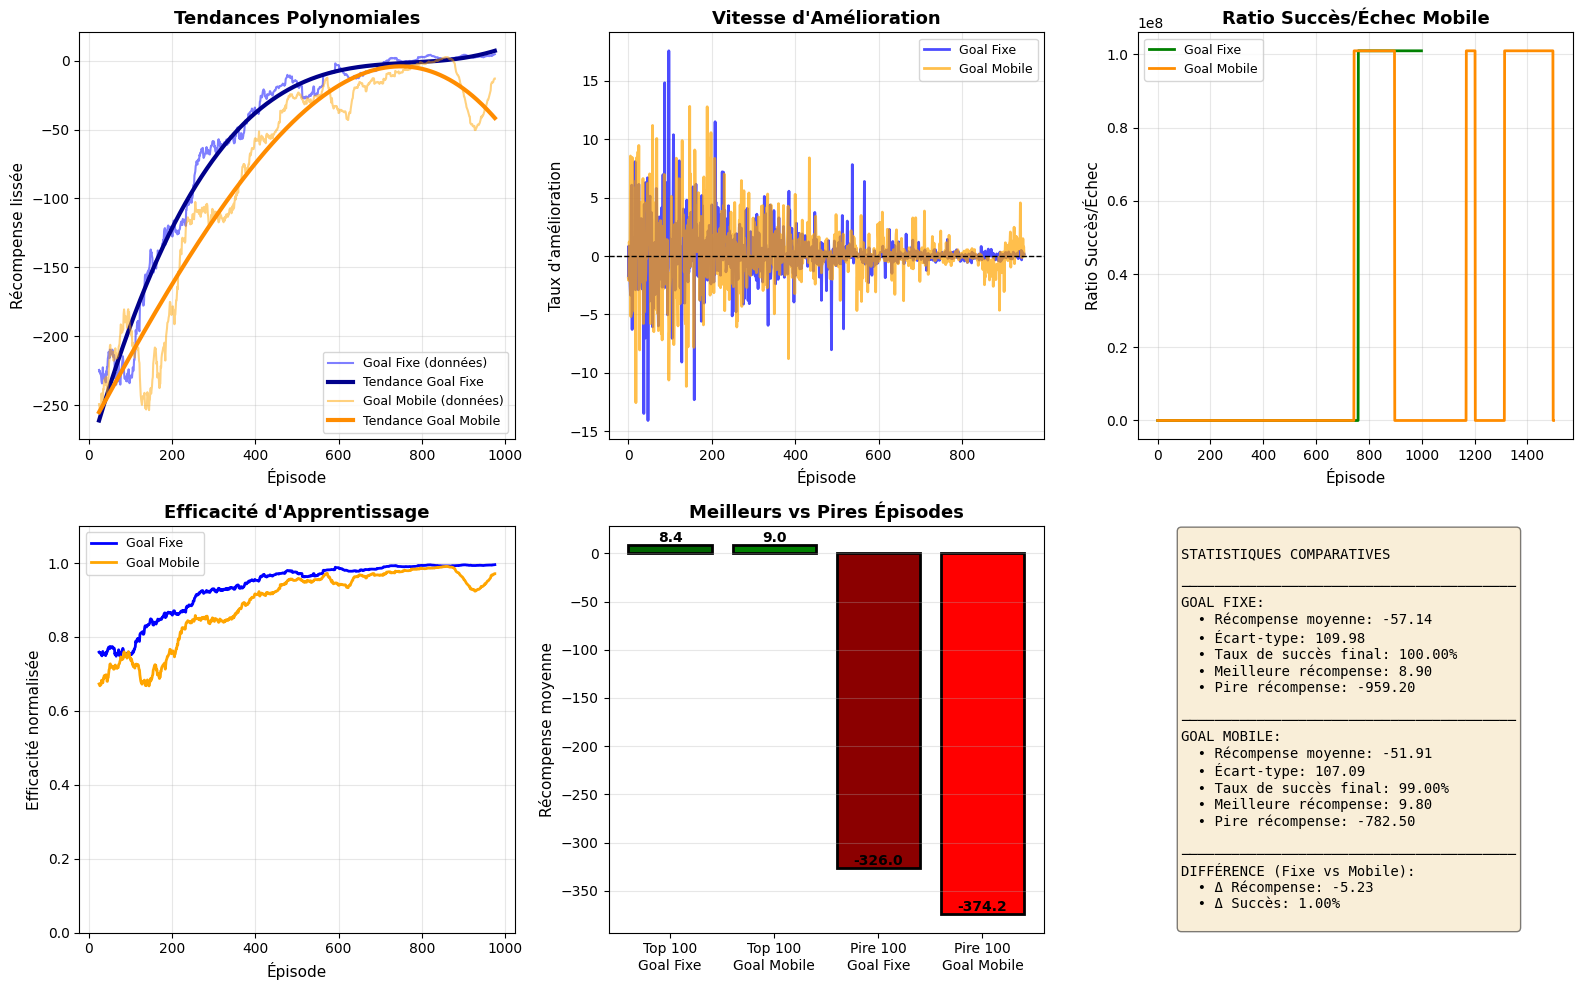

In [279]:
# 4. Métriques de performance avancées
plt.figure(figsize=(16, 10))

# Subplot 1: Tendance polynomiale
plt.subplot(2, 3, 1)
window = 50
smoothed_fixed = moving_average(rewards_fixed, window)
smoothed_moving = moving_average(rewards_moving[:len(rewards_fixed)], window)
x = np.arange(len(smoothed_fixed)) + window // 2

# Ajustement polynomial de degré 3
z_fixed = np.polyfit(x, smoothed_fixed, 3)
p_fixed = np.poly1d(z_fixed)
z_moving = np.polyfit(x, smoothed_moving, 3)
p_moving = np.poly1d(z_moving)

plt.plot(x, smoothed_fixed, alpha=0.5, color='blue', label='Goal Fixe (données)')
plt.plot(x, p_fixed(x), linewidth=3, color='darkblue', label='Tendance Goal Fixe')
plt.plot(x, smoothed_moving, alpha=0.5, color='orange', label='Goal Mobile (données)')
plt.plot(x, p_moving(x), linewidth=3, color='darkorange', label='Tendance Goal Mobile')
plt.xlabel("Épisode", fontsize=11)
plt.ylabel("Récompense lissée", fontsize=11)
plt.title("Tendances Polynomiales", fontsize=13, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Subplot 2: Taux d'amélioration (dérivée)
plt.subplot(2, 3, 2)
improvement_fixed = np.diff(smoothed_fixed)
improvement_moving = np.diff(smoothed_moving)
plt.plot(improvement_fixed, linewidth=2, color='blue', label='Goal Fixe', alpha=0.7)
plt.plot(improvement_moving, linewidth=2, color='orange', label='Goal Mobile', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Épisode", fontsize=11)
plt.ylabel("Taux d'amélioration", fontsize=11)
plt.title("Vitesse d'Amélioration", fontsize=13, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Subplot 3: Ratio succès/échec
plt.subplot(2, 3, 3)
window_ratio = 100
success_ratio_fixed = [np.sum(successes_fixed[max(0, i-window_ratio):i+1]) / 
                       (len(successes_fixed[max(0, i-window_ratio):i+1]) - 
                        np.sum(successes_fixed[max(0, i-window_ratio):i+1]) + 1e-6)
                       for i in range(len(successes_fixed))]
success_ratio_moving = [np.sum(successes_moving[max(0, i-window_ratio):i+1]) / 
                        (len(successes_moving[max(0, i-window_ratio):i+1]) - 
                         np.sum(successes_moving[max(0, i-window_ratio):i+1]) + 1e-6)
                        for i in range(len(successes_moving))]
plt.plot(success_ratio_fixed, linewidth=2, color='green', label='Goal Fixe')
plt.plot(success_ratio_moving, linewidth=2, color='darkorange', label='Goal Mobile')
plt.xlabel("Épisode", fontsize=11)
plt.ylabel("Ratio Succès/Échec", fontsize=11)
plt.title("Ratio Succès/Échec Mobile", fontsize=13, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Subplot 4: Efficacité d'apprentissage (récompense par épisode normalisée)
plt.subplot(2, 3, 4)
efficiency_fixed = (rewards_fixed - np.min(rewards_fixed)) / (np.max(rewards_fixed) - np.min(rewards_fixed) + 1e-6)
efficiency_moving = (rewards_moving[:len(rewards_fixed)] - np.min(rewards_moving[:len(rewards_fixed)])) / \
                    (np.max(rewards_moving[:len(rewards_fixed)]) - np.min(rewards_moving[:len(rewards_fixed)]) + 1e-6)
smoothed_eff_fixed = moving_average(efficiency_fixed, 50)
smoothed_eff_moving = moving_average(efficiency_moving, 50)
plt.plot(np.arange(len(smoothed_eff_fixed)) + 25, smoothed_eff_fixed, 
         linewidth=2, color='blue', label='Goal Fixe')
plt.plot(np.arange(len(smoothed_eff_moving)) + 25, smoothed_eff_moving, 
         linewidth=2, color='orange', label='Goal Mobile')
plt.xlabel("Épisode", fontsize=11)
plt.ylabel("Efficacité normalisée", fontsize=11)
plt.title("Efficacité d'Apprentissage", fontsize=13, fontweight='bold')
plt.ylim(0, 1.1)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Subplot 5: Comparaison des meilleurs vs pires épisodes
plt.subplot(2, 3, 5)
top_n = 100
top_fixed = np.sort(rewards_fixed)[-top_n:]
top_moving = np.sort(rewards_moving[:len(rewards_fixed)])[-top_n:]
bottom_fixed = np.sort(rewards_fixed)[:top_n]
bottom_moving = np.sort(rewards_moving[:len(rewards_fixed)])[:top_n]

categories = ['Top 100\nGoal Fixe', 'Top 100\nGoal Mobile', 'Pire 100\nGoal Fixe', 'Pire 100\nGoal Mobile']
means = [np.mean(top_fixed), np.mean(top_moving), np.mean(bottom_fixed), np.mean(bottom_moving)]
colors_bar = ['darkgreen', 'green', 'darkred', 'red']
bars = plt.bar(categories, means, color=colors_bar, edgecolor='black', linewidth=2)
plt.ylabel("Récompense moyenne", fontsize=11)
plt.title("Meilleurs vs Pires Épisodes", fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
for i, (bar, val) in enumerate(zip(bars, means)):
    plt.text(bar.get_x() + bar.get_width()/2., val,
             f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Subplot 6: Statistiques récapitulatives
plt.subplot(2, 3, 6)
plt.axis('off')
stats_text = f"""
STATISTIQUES COMPARATIVES

{'─'*40}
GOAL FIXE:
  • Récompense moyenne: {np.mean(rewards_fixed):.2f}
  • Écart-type: {np.std(rewards_fixed):.2f}
  • Taux de succès final: {np.mean(successes_fixed[-100:]):.2%}
  • Meilleure récompense: {np.max(rewards_fixed):.2f}
  • Pire récompense: {np.min(rewards_fixed):.2f}

{'─'*40}
GOAL MOBILE:
  • Récompense moyenne: {np.mean(rewards_moving):.2f}
  • Écart-type: {np.std(rewards_moving):.2f}
  • Taux de succès final: {np.mean(successes_moving[-100:]):.2%}
  • Meilleure récompense: {np.max(rewards_moving):.2f}
  • Pire récompense: {np.min(rewards_moving):.2f}

{'─'*40}
DIFFÉRENCE (Fixe vs Mobile):
  • Δ Récompense: {np.mean(rewards_fixed) - np.mean(rewards_moving):.2f}
  • Δ Succès: {(np.mean(successes_fixed[-100:]) - np.mean(successes_moving[-100:])):.2%}
"""
plt.text(0.1, 0.5, stats_text, fontsize=10, family='monospace', 
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

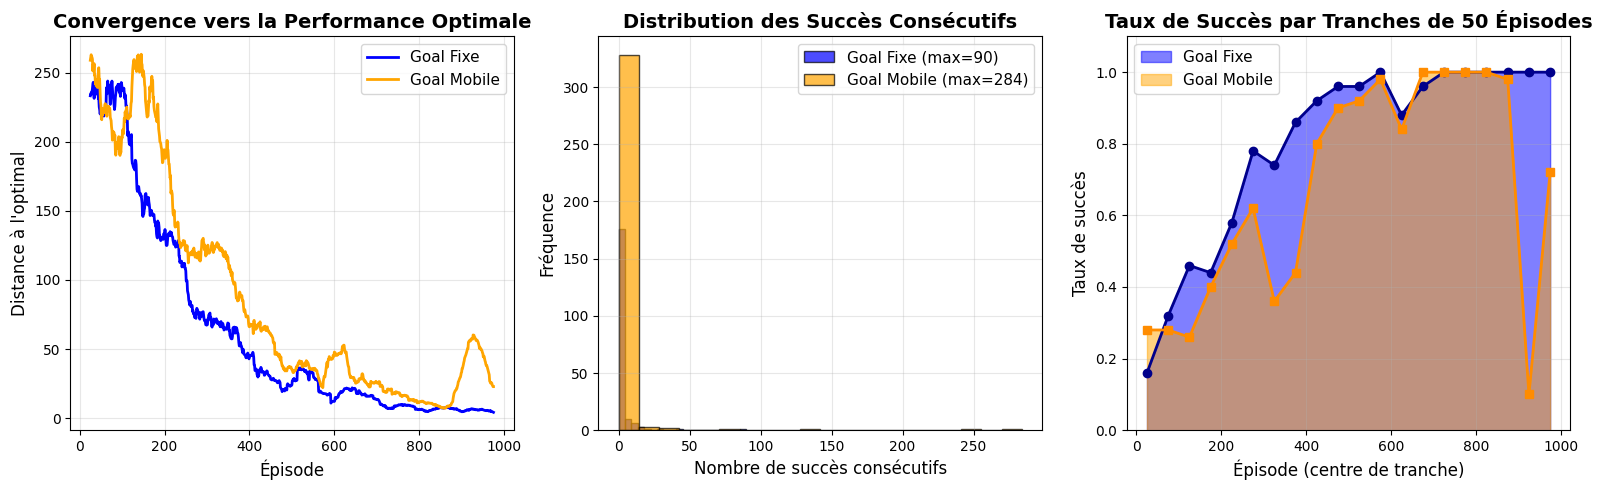

In [280]:
# 5. Analyse de convergence et stabilité
plt.figure(figsize=(16, 5))

# Subplot 1: Convergence vers l'optimalité
plt.subplot(1, 3, 1)
# Calculer la récompense maximale théorique observée
max_reward_fixed = np.max(rewards_fixed)
max_reward_moving = np.max(rewards_moving)

# Distance à l'optimal (moyenne mobile)
distance_to_optimal_fixed = moving_average(max_reward_fixed - rewards_fixed, 50)
distance_to_optimal_moving = moving_average(max_reward_moving - rewards_moving[:len(rewards_fixed)], 50)

plt.plot(np.arange(len(distance_to_optimal_fixed)) + 25, distance_to_optimal_fixed, 
         linewidth=2, color='blue', label='Goal Fixe')
plt.plot(np.arange(len(distance_to_optimal_moving)) + 25, distance_to_optimal_moving, 
         linewidth=2, color='orange', label='Goal Mobile')
plt.xlabel("Épisode", fontsize=12)
plt.ylabel("Distance à l'optimal", fontsize=12)
plt.title("Convergence vers la Performance Optimale", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Subplot 2: Episodes consécutifs réussis
plt.subplot(1, 3, 2)
consecutive_success_fixed = []
consecutive_success_moving = []
count_fixed = 0
count_moving = 0

for i in range(len(successes_fixed)):
    if successes_fixed[i]:
        count_fixed += 1
    else:
        consecutive_success_fixed.append(count_fixed)
        count_fixed = 0
    
for i in range(len(successes_moving)):
    if successes_moving[i]:
        count_moving += 1
    else:
        consecutive_success_moving.append(count_moving)
        count_moving = 0

plt.hist(consecutive_success_fixed, bins=20, alpha=0.7, color='blue', 
         label=f'Goal Fixe (max={max(consecutive_success_fixed) if consecutive_success_fixed else 0})', 
         edgecolor='black')
plt.hist(consecutive_success_moving, bins=20, alpha=0.7, color='orange', 
         label=f'Goal Mobile (max={max(consecutive_success_moving) if consecutive_success_moving else 0})', 
         edgecolor='black')
plt.xlabel("Nombre de succès consécutifs", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.title("Distribution des Succès Consécutifs", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Subplot 3: Taux de succès par tranches de 50 épisodes
plt.subplot(1, 3, 3)
slice_size = 50
num_slices = len(rewards_fixed) // slice_size
success_rate_slices_fixed = [np.mean(successes_fixed[i*slice_size:(i+1)*slice_size]) 
                              for i in range(num_slices)]
success_rate_slices_moving = [np.mean(successes_moving[i*slice_size:(i+1)*slice_size]) 
                               for i in range(num_slices)]

x_slices = np.arange(num_slices) * slice_size + slice_size // 2
plt.fill_between(x_slices, 0, success_rate_slices_fixed, alpha=0.5, color='blue', label='Goal Fixe')
plt.fill_between(x_slices, 0, success_rate_slices_moving, alpha=0.5, color='orange', label='Goal Mobile')
plt.plot(x_slices, success_rate_slices_fixed, linewidth=2, color='darkblue', marker='o')
plt.plot(x_slices, success_rate_slices_moving, linewidth=2, color='darkorange', marker='s')
plt.xlabel("Épisode (centre de tranche)", fontsize=12)
plt.ylabel("Taux de succès", fontsize=12)
plt.title(f"Taux de Succès par Tranches de {slice_size} Épisodes", fontsize=14, fontweight='bold')
plt.ylim(0, 1.1)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [281]:
# 6. Tableau récapitulatif comparatif détaillé
print("\n" + "╔" + "="*88 + "╗")
print("║" + " "*28 + "ANALYSE COMPARATIVE DÉTAILLÉE" + " "*31 + "║")
print("╠" + "="*88 + "╣")

metrics = {
    'Métrique': [
        'Récompense Moyenne',
        'Récompense Médiane',
        'Écart-type Récompense',
        'Min Récompense',
        'Max Récompense',
        '',
        'Taux Succès Global',
        'Taux Succès (100 derniers)',
        'Taux Succès (100 premiers)',
        '',
        'Épisodes pour 50% succès',
        'Épisodes pour 80% succès',
        'Max Succès Consécutifs',
        '',
        'Variance Stabilisée',
        'Coefficient de Variation'
    ],
    'Goal Fixe': [],
    'Goal Mobile': [],
    'Différence': []
}

# Calculer les métriques
mean_rew_f = np.mean(rewards_fixed)
mean_rew_m = np.mean(rewards_moving)
median_rew_f = np.median(rewards_fixed)
median_rew_m = np.median(rewards_moving)
std_rew_f = np.std(rewards_fixed)
std_rew_m = np.std(rewards_moving)
min_rew_f = np.min(rewards_fixed)
min_rew_m = np.min(rewards_moving)
max_rew_f = np.max(rewards_fixed)
max_rew_m = np.max(rewards_moving)

success_global_f = np.mean(successes_fixed)
success_global_m = np.mean(successes_moving)
success_last100_f = np.mean(successes_fixed[-100:])
success_last100_m = np.mean(successes_moving[-100:])
success_first100_f = np.mean(successes_fixed[:100])
success_first100_m = np.mean(successes_moving[:100])

# Trouver l'épisode où le taux atteint 50% et 80%
def find_success_episode(successes, threshold, window=50):
    for i in range(window, len(successes)):
        if np.mean(successes[i-window:i]) >= threshold:
            return i
    return 'N/A'

ep_50_f = find_success_episode(successes_fixed, 0.5)
ep_50_m = find_success_episode(successes_moving, 0.5)
ep_80_f = find_success_episode(successes_fixed, 0.8)
ep_80_m = find_success_episode(successes_moving, 0.8)

max_consec_f = max(consecutive_success_fixed) if consecutive_success_fixed else 0
max_consec_m = max(consecutive_success_moving) if consecutive_success_moving else 0

var_stab_f = np.var(rewards_fixed[-100:])
var_stab_m = np.var(rewards_moving[-100:])
cv_f = std_rew_f / abs(mean_rew_f) if mean_rew_f != 0 else 0
cv_m = std_rew_m / abs(mean_rew_m) if mean_rew_m != 0 else 0

# Remplir le tableau
metrics['Goal Fixe'] = [
    f"{mean_rew_f:.2f}",
    f"{median_rew_f:.2f}",
    f"{std_rew_f:.2f}",
    f"{min_rew_f:.2f}",
    f"{max_rew_f:.2f}",
    "",
    f"{success_global_f:.2%}",
    f"{success_last100_f:.2%}",
    f"{success_first100_f:.2%}",
    "",
    f"{ep_50_f}",
    f"{ep_80_f}",
    f"{max_consec_f}",
    "",
    f"{var_stab_f:.2f}",
    f"{cv_f:.3f}"
]

metrics['Goal Mobile'] = [
    f"{mean_rew_m:.2f}",
    f"{median_rew_m:.2f}",
    f"{std_rew_m:.2f}",
    f"{min_rew_m:.2f}",
    f"{max_rew_m:.2f}",
    "",
    f"{success_global_m:.2%}",
    f"{success_last100_m:.2%}",
    f"{success_first100_m:.2%}",
    "",
    f"{ep_50_m}",
    f"{ep_80_m}",
    f"{max_consec_m}",
    "",
    f"{var_stab_m:.2f}",
    f"{cv_m:.3f}"
]

metrics['Différence'] = [
    f"{mean_rew_f - mean_rew_m:+.2f}",
    f"{median_rew_f - median_rew_m:+.2f}",
    f"{std_rew_f - std_rew_m:+.2f}",
    f"{min_rew_f - min_rew_m:+.2f}",
    f"{max_rew_f - max_rew_m:+.2f}",
    "",
    f"{success_global_f - success_global_m:+.2%}",
    f"{success_last100_f - success_last100_m:+.2%}",
    f"{success_first100_f - success_first100_m:+.2%}",
    "",
    "-",
    "-",
    f"{max_consec_f - max_consec_m:+d}",
    "",
    f"{var_stab_f - var_stab_m:+.2f}",
    f"{cv_f - cv_m:+.3f}"
]

# Afficher le tableau
print(f"║ {'Métrique':<30} │ {'Goal Fixe':<15} │ {'Goal Mobile':<15} │ {'Δ Diff.':<10} ║")
print("╠" + "─"*31 + "┼" + "─"*17 + "┼" + "─"*17 + "┼" + "─"*11 + "╣")

for i, metric in enumerate(metrics['Métrique']):
    if metric == '':
        print("╠" + "─"*31 + "┼" + "─"*17 + "┼" + "─"*17 + "┼" + "─"*11 + "╣")
    else:
        print(f"║ {metric:<30} │ {metrics['Goal Fixe'][i]:>15} │ {metrics['Goal Mobile'][i]:>15} │ {metrics['Différence'][i]:>10} ║")

print("╚" + "="*88 + "╝")


╔========================================================================================╗
║                            ANALYSE COMPARATIVE DÉTAILLÉE                               ║
╠========================================================================================╣
║ Métrique                       │ Goal Fixe       │ Goal Mobile     │ Δ Diff.    ║
╠───────────────────────────────┼─────────────────┼─────────────────┼───────────╣
║ Récompense Moyenne             │          -57.14 │          -51.91 │      -5.23 ║
║ Récompense Médiane             │           -9.20 │           -6.50 │      -2.70 ║
║ Écart-type Récompense          │          109.98 │          107.09 │      +2.89 ║
║ Min Récompense                 │         -959.20 │         -782.50 │    -176.70 ║
║ Max Récompense                 │            8.90 │            9.80 │      -0.90 ║
╠───────────────────────────────┼─────────────────┼─────────────────┼───────────╣
║ Taux Succès Global             │          80.10% │      

---
## Partie 3: Analyse Multi-Tailles (Scalabilité)


### Configuration Multi-Tailles

In [282]:
# Configuration pour tester plusieurs tailles de grilles
random.seed(100)
np.random.seed(100)

# Tailles de grilles à tester
GRID_SIZES = [4, 5, 6, 7, 8, 10]
EPISODES_MULTI = 800
MAX_STEPS_MULTI = 100

# Dictionnaires pour stocker les résultats
multi_rewards = {}
multi_successes = {}
multi_Q_tables = {}

print("="*70)
print("ANALYSE MULTI-TAILLES")
print("="*70)
print(f"Tailles testées: {GRID_SIZES}")
print(f"Épisodes par taille: {EPISODES_MULTI}")
print(f"Steps maximum: {MAX_STEPS_MULTI}")
print("="*70)

ANALYSE MULTI-TAILLES
Tailles testées: [4, 5, 6, 7, 8, 10]
Épisodes par taille: 800
Steps maximum: 100


In [283]:
# Entraînement sur chaque taille de grille
for size in GRID_SIZES:
    print(f"\n{'='*70}")
    print(f"Entraînement sur grille {size}x{size}")
    print(f"{'='*70}")
    
    # Créer le goal (coin inférieur droit)
    goal_multi = (size - 1, size - 1)
    
    # Générer des obstacles aléatoires
    rng = random.Random(size * 10)
    num_obstacles = max(1, size // 2)  # Nombre d'obstacles proportionnel à la taille
    obstacles_multi = []
    
    while len(obstacles_multi) < num_obstacles:
        ox = rng.randint(0, size - 1)
        oy = rng.randint(0, size - 1)
        pos = (ox, oy)
        if pos != (0, 0) and pos != goal_multi and pos not in obstacles_multi:
            obstacles_multi.append(pos)
    
    print(f"Goal: {goal_multi}")
    print(f"Obstacles ({num_obstacles}): {obstacles_multi}")
    
    # Créer l'environnement
    env_multi = GridWorld(
        size=size,
        goals=[goal_multi],
        obstacles=obstacles_multi,
        max_steps=MAX_STEPS_MULTI,
        dynamic_elements=False,
        obstacle_penalty=-5.0,
        step_penalty=-0.1,
        goal_reward=10.0
    )
    
    # Entraîner sans enregistrement vidéo pour aller plus vite
    Q, rewards, successes, _ = q_learning_with_video(
        env_multi,
        episodes=EPISODES_MULTI,
        alpha=ALPHA,
        gamma=GAMMA,
        eps_start=EPS_START,
        eps_end=EPS_END,
        record_episodes=[]  # Pas d'enregistrement
    )
    
    # Stocker les résultats
    multi_rewards[size] = rewards
    multi_successes[size] = successes
    multi_Q_tables[size] = Q
    
    # Afficher les statistiques
    final_success_rate = np.mean(successes[-100:])
    final_reward = np.mean(rewards[-100:])
    print(f"\n✓ Entraînement terminé!")
    print(f"  Taux de réussite final: {final_success_rate:.2%}")
    print(f"  Récompense moyenne finale: {final_reward:.2f}")

print(f"\n{'='*70}")
print("TOUS LES ENTRAÎNEMENTS TERMINÉS!")
print(f"{'='*70}")


Entraînement sur grille 4x4
Goal: (3, 3)
Obstacles (2): [(3, 0), (1, 2)]

✓ Entraînement terminé!
  Taux de réussite final: 100.00%
  Récompense moyenne finale: 6.31

Entraînement sur grille 5x5
Goal: (4, 4)
Obstacles (2): [(3, 2), (2, 1)]

✓ Entraînement terminé!
  Taux de réussite final: 100.00%
  Récompense moyenne finale: 8.61

Entraînement sur grille 6x6
Goal: (5, 5)
Obstacles (3): [(2, 2), (4, 1), (2, 1)]

✓ Entraînement terminé!
  Taux de réussite final: 100.00%
  Récompense moyenne finale: 8.61

Entraînement sur grille 6x6
Goal: (5, 5)
Obstacles (3): [(2, 2), (4, 1), (2, 1)]

✓ Entraînement terminé!
  Taux de réussite final: 100.00%
  Récompense moyenne finale: 8.23

Entraînement sur grille 7x7
Goal: (6, 6)
Obstacles (3): [(0, 2), (5, 3), (3, 1)]

✓ Entraînement terminé!
  Taux de réussite final: 100.00%
  Récompense moyenne finale: 8.23

Entraînement sur grille 7x7
Goal: (6, 6)
Obstacles (3): [(0, 2), (5, 3), (3, 1)]

✓ Entraînement terminé!
  Taux de réussite final: 100.00%


### Visualisation des Courbes d'Apprentissage Multi-Tailles

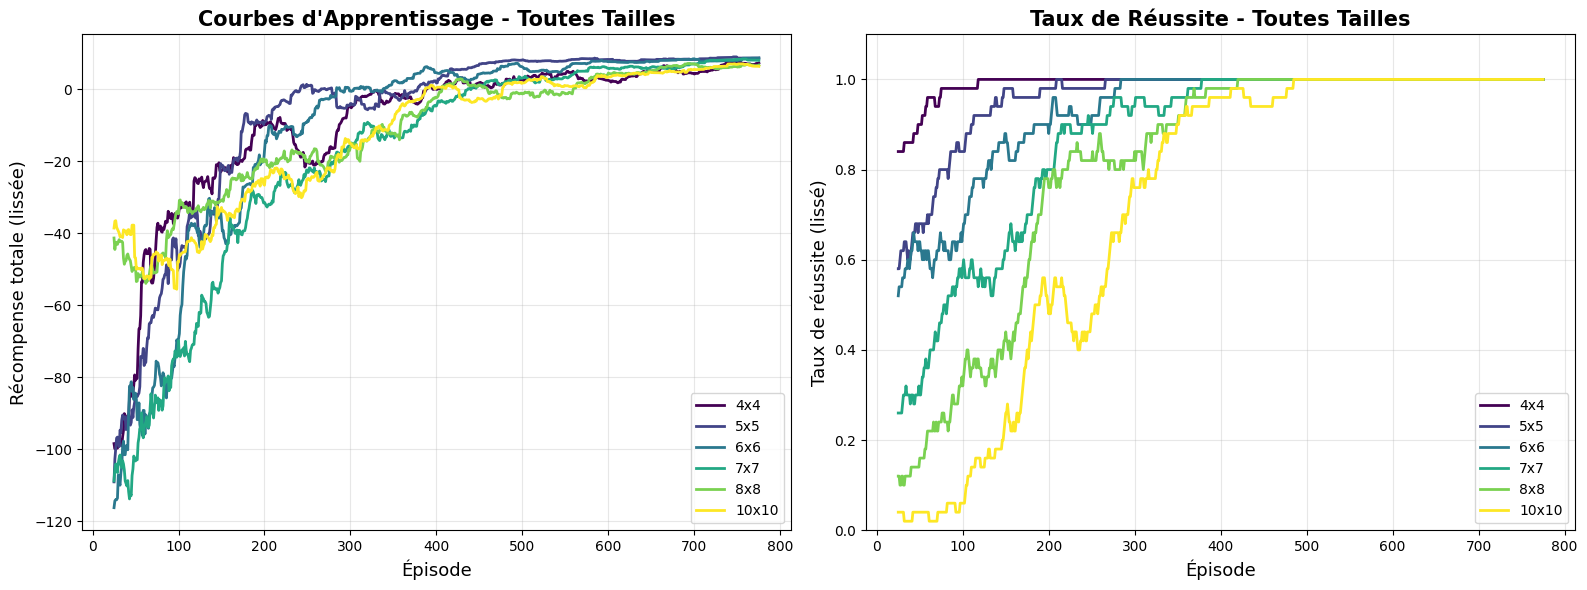

In [284]:
# Visualisation des courbes d'apprentissage pour toutes les tailles
plt.figure(figsize=(16, 6))

# Subplot 1: Récompenses lissées
plt.subplot(1, 2, 1)
window = 50
colors = plt.cm.viridis(np.linspace(0, 1, len(GRID_SIZES)))

for idx, size in enumerate(GRID_SIZES):
    rewards = multi_rewards[size]
    smoothed = moving_average(rewards, window)
    plt.plot(np.arange(len(smoothed)) + window // 2, smoothed, 
             label=f"{size}x{size}", linewidth=2, color=colors[idx])

plt.xlabel("Épisode", fontsize=13)
plt.ylabel("Récompense totale (lissée)", fontsize=13)
plt.title("Courbes d'Apprentissage - Toutes Tailles", fontsize=15, fontweight='bold')
plt.legend(fontsize=10, loc='lower right')
plt.grid(True, alpha=0.3)

# Subplot 2: Taux de réussite lissés
plt.subplot(1, 2, 2)
for idx, size in enumerate(GRID_SIZES):
    successes = multi_successes[size]
    smoothed = moving_average(successes.astype(float), window)
    plt.plot(np.arange(len(smoothed)) + window // 2, smoothed, 
             label=f"{size}x{size}", linewidth=2, color=colors[idx])

plt.xlabel("Épisode", fontsize=13)
plt.ylabel("Taux de réussite (lissé)", fontsize=13)
plt.title("Taux de Réussite - Toutes Tailles", fontsize=15, fontweight='bold')
plt.ylim(0, 1.1)
plt.legend(fontsize=10, loc='lower right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Analyse de Performance par Taille

In [285]:
# Analyse des performances finales
final_stats = {
    'size': [],
    'success_rate': [],
    'avg_reward': [],
    'convergence_episode': []  # Episode où le taux de réussite dépasse 80%
}

print("\n" + "="*80)
print("ANALYSE DE PERFORMANCE PAR TAILLE DE GRILLE")
print("="*80)
print(f"{'Taille':<10} {'Taux Réussite':<20} {'Récompense Moy.':<20} {'Convergence':<15}")
print("-"*80)

for size in GRID_SIZES:
    successes = multi_successes[size]
    rewards = multi_rewards[size]
    
    # Taux de réussite final (100 derniers épisodes)
    final_success = np.mean(successes[-100:])
    
    # Récompense moyenne finale
    final_reward = np.mean(rewards[-100:])
    
    # Trouver l'épisode de convergence (première fois où le taux dépasse 80% sur 50 épisodes)
    window_conv = 50
    convergence_ep = None
    for i in range(window_conv, len(successes)):
        if np.mean(successes[i-window_conv:i]) >= 0.8:
            convergence_ep = i
            break
    
    final_stats['size'].append(size)
    final_stats['success_rate'].append(final_success)
    final_stats['avg_reward'].append(final_reward)
    final_stats['convergence_episode'].append(convergence_ep if convergence_ep else 'N/A')
    
    conv_str = f"{convergence_ep}" if convergence_ep else "N/A"
    print(f"{size}x{size:<7} {final_success*100:>6.2f}%{'':<13} {final_reward:>8.2f}{'':<12} {conv_str:<15}")

print("="*80)


ANALYSE DE PERFORMANCE PAR TAILLE DE GRILLE
Taille     Taux Réussite        Récompense Moy.      Convergence    
--------------------------------------------------------------------------------
4x4       100.00%                  6.31             50             
5x5       100.00%                  8.61             98             
6x6       100.00%                  8.23             153            
7x7       100.00%                  8.01             218            
8x8       100.00%                  6.15             230            
10x10      100.00%                  6.29             341            


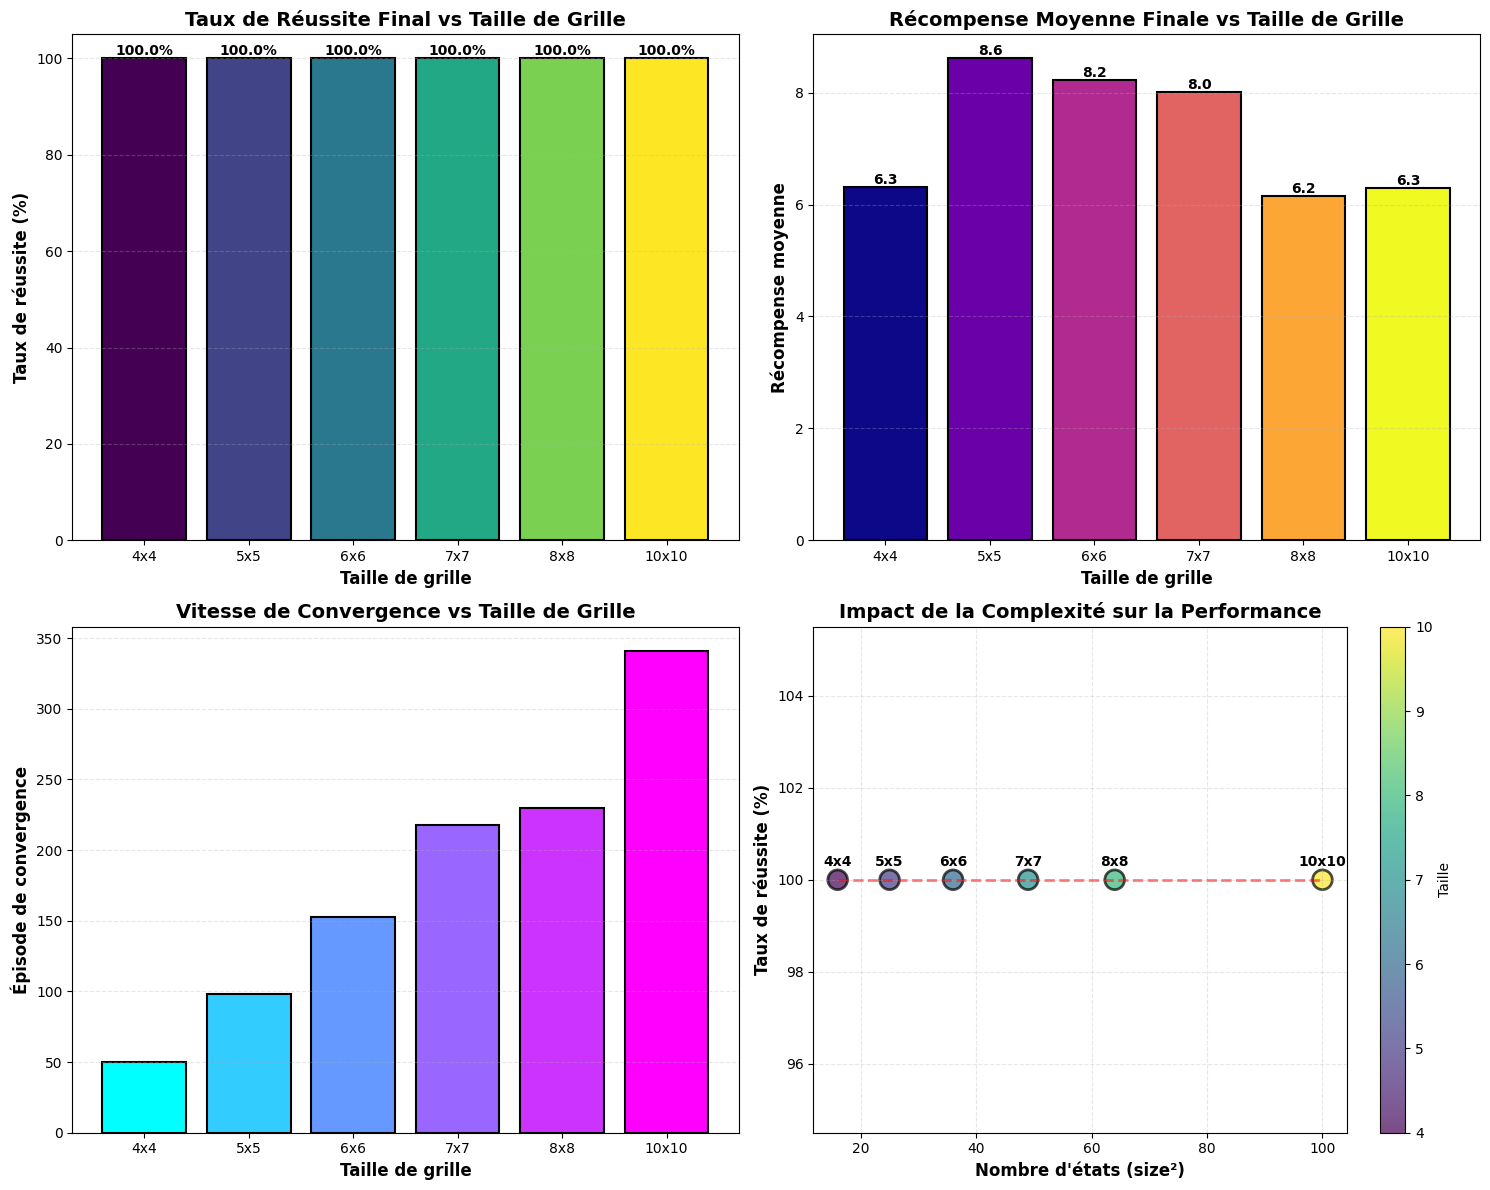

In [286]:
# Graphiques d'analyse de performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Graphique 1: Taux de réussite final par taille
ax1 = axes[0, 0]
bars1 = ax1.bar(range(len(GRID_SIZES)), 
                [s * 100 for s in final_stats['success_rate']], 
                color=plt.cm.viridis(np.linspace(0, 1, len(GRID_SIZES))),
                edgecolor='black', linewidth=1.5)
ax1.set_xlabel("Taille de grille", fontsize=12, fontweight='bold')
ax1.set_ylabel("Taux de réussite (%)", fontsize=12, fontweight='bold')
ax1.set_title("Taux de Réussite Final vs Taille de Grille", fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(GRID_SIZES)))
ax1.set_xticklabels([f"{s}x{s}" for s in GRID_SIZES])
ax1.set_ylim(0, 105)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Graphique 2: Récompense moyenne finale par taille
ax2 = axes[0, 1]
bars2 = ax2.bar(range(len(GRID_SIZES)), 
                final_stats['avg_reward'], 
                color=plt.cm.plasma(np.linspace(0, 1, len(GRID_SIZES))),
                edgecolor='black', linewidth=1.5)
ax2.set_xlabel("Taille de grille", fontsize=12, fontweight='bold')
ax2.set_ylabel("Récompense moyenne", fontsize=12, fontweight='bold')
ax2.set_title("Récompense Moyenne Finale vs Taille de Grille", fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(GRID_SIZES)))
ax2.set_xticklabels([f"{s}x{s}" for s in GRID_SIZES])
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Graphique 3: Épisode de convergence par taille
ax3 = axes[1, 0]
convergence_values = [c if isinstance(c, int) else EPISODES_MULTI for c in final_stats['convergence_episode']]
bars3 = ax3.bar(range(len(GRID_SIZES)), 
                convergence_values, 
                color=plt.cm.cool(np.linspace(0, 1, len(GRID_SIZES))),
                edgecolor='black', linewidth=1.5)
ax3.set_xlabel("Taille de grille", fontsize=12, fontweight='bold')
ax3.set_ylabel("Épisode de convergence", fontsize=12, fontweight='bold')
ax3.set_title("Vitesse de Convergence vs Taille de Grille", fontsize=14, fontweight='bold')
ax3.set_xticks(range(len(GRID_SIZES)))
ax3.set_xticklabels([f"{s}x{s}" for s in GRID_SIZES])
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Graphique 4: Complexité (nombre d'états vs performance)
ax4 = axes[1, 1]
num_states = [s*s for s in GRID_SIZES]
scatter = ax4.scatter(num_states, 
                      [s * 100 for s in final_stats['success_rate']],
                      s=200, c=GRID_SIZES, cmap='viridis',
                      edgecolors='black', linewidths=2, alpha=0.7)
ax4.plot(num_states, [s * 100 for s in final_stats['success_rate']], 
         'r--', alpha=0.5, linewidth=2)
ax4.set_xlabel("Nombre d'états (size²)", fontsize=12, fontweight='bold')
ax4.set_ylabel("Taux de réussite (%)", fontsize=12, fontweight='bold')
ax4.set_title("Impact de la Complexité sur la Performance", fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, linestyle='--')

# Ajouter les labels
for i, (x, y) in enumerate(zip(num_states, [s * 100 for s in final_stats['success_rate']])):
    ax4.annotate(f"{GRID_SIZES[i]}x{GRID_SIZES[i]}", 
                (x, y), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10, fontweight='bold')

plt.colorbar(scatter, ax=ax4, label='Taille')

plt.tight_layout()
plt.show()

### Visualisations Avancées Multi-Tailles (Style Recherche)

C:\Users\Rog strix Scar\AppData\Local\Temp\ipykernel_7252\502102174.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


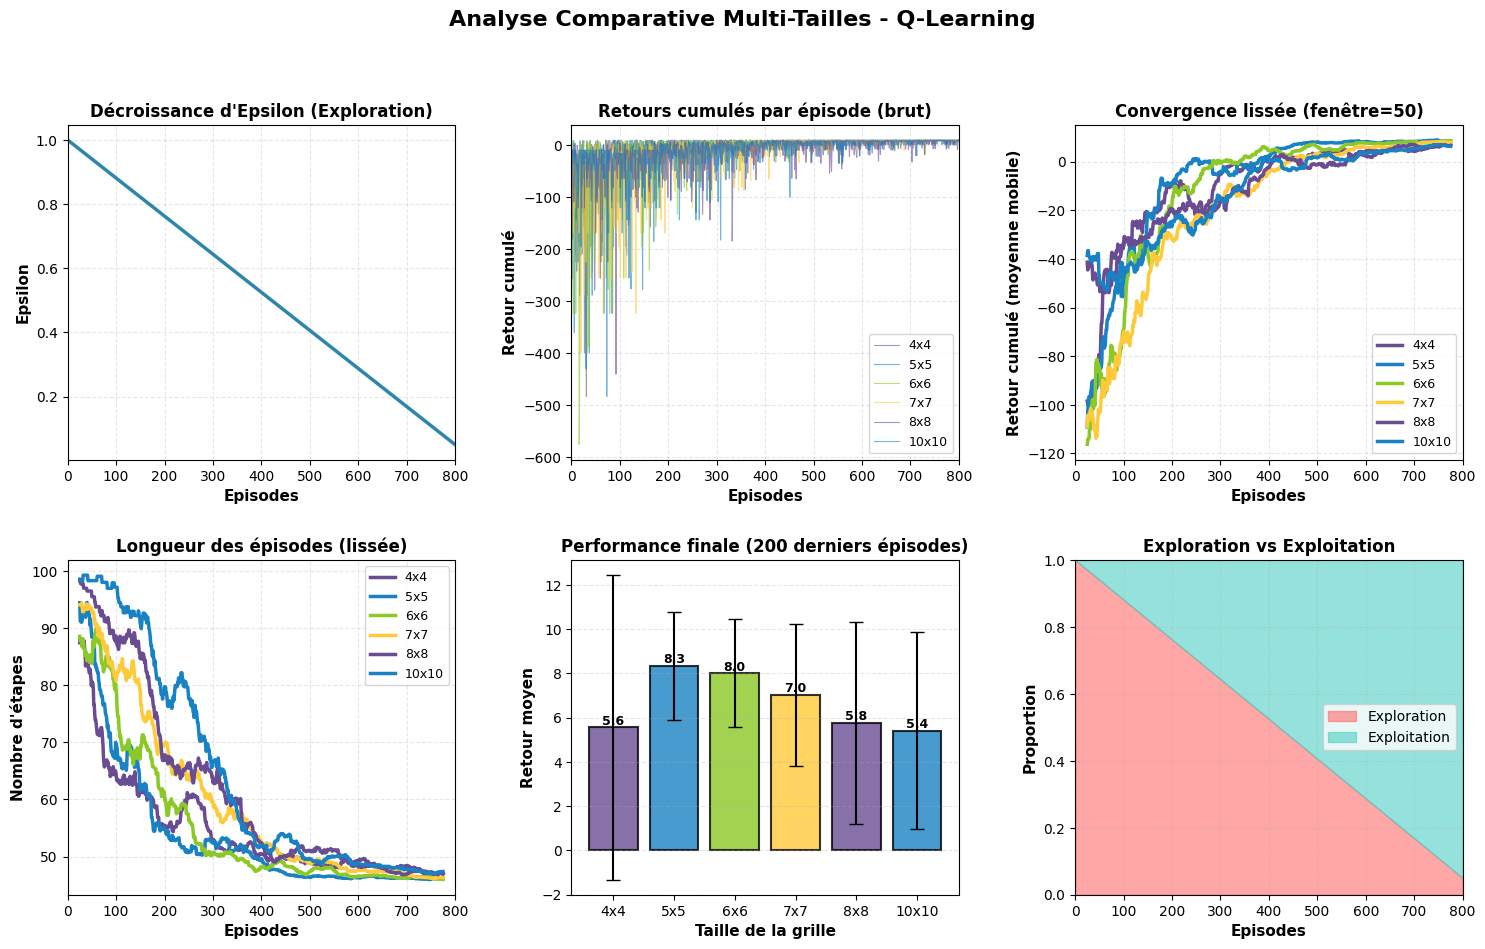

In [287]:
# Figure avec 6 sous-graphiques (2x3) - Style Recherche
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Décroissance d'Epsilon (Exploration)
ax1 = fig.add_subplot(gs[0, 0])
eps_decay_multi = EPISODES_MULTI
epsilon_curve = [max(EPS_END, EPS_START - (EPS_START - EPS_END) * (ep / eps_decay_multi)) 
                 for ep in range(EPISODES_MULTI)]
ax1.plot(epsilon_curve, linewidth=2.5, color='#2E86AB')
ax1.set_xlabel('Episodes', fontsize=11, fontweight='bold')
ax1.set_ylabel('Epsilon', fontsize=11, fontweight='bold')
ax1.set_title("Décroissance d'Epsilon (Exploration)", fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xlim(0, len(epsilon_curve))

# 2. Retours cumulés par épisode (brut) - Toutes les tailles
ax2 = fig.add_subplot(gs[0, 1])
colors_multi = ['#6A4C93', '#1982C4', '#8AC926', '#FFCA3A']
for idx, size in enumerate(GRID_SIZES):
    rewards_data = multi_rewards[size]
    # Afficher toutes les récompenses brutes avec transparence
    ax2.plot(rewards_data, alpha=0.6, linewidth=0.8, color=colors_multi[idx % len(colors_multi)], 
             label=f'{size}x{size}')
ax2.set_xlabel('Episodes', fontsize=11, fontweight='bold')
ax2.set_ylabel('Retour cumulé', fontsize=11, fontweight='bold')
ax2.set_title('Retours cumulés par épisode (brut)', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xlim(0, EPISODES_MULTI)

# 3. Convergence lissée (fenêtre=50)
ax3 = fig.add_subplot(gs[0, 2])
window_smooth = 50
for idx, size in enumerate(GRID_SIZES):
    rewards_data = multi_rewards[size]
    smoothed = moving_average(rewards_data, window_smooth)
    x_smooth = np.arange(len(smoothed)) + window_smooth // 2
    ax3.plot(x_smooth, smoothed, linewidth=2.5, color=colors_multi[idx % len(colors_multi)], 
             label=f'{size}x{size}')
ax3.set_xlabel('Episodes', fontsize=11, fontweight='bold')
ax3.set_ylabel('Retour cumulé (moyenne mobile)', fontsize=11, fontweight='bold')
ax3.set_title(f'Convergence lissée (fenêtre={window_smooth})', fontsize=12, fontweight='bold')
ax3.legend(loc='lower right', fontsize=9)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.set_xlim(0, EPISODES_MULTI)

# 4. Longueur des épisodes (lissée)
ax4 = fig.add_subplot(gs[1, 0])
# Simuler la longueur des épisodes basée sur les récompenses
# Plus la récompense est haute, plus l'épisode était court (succès rapide)
for idx, size in enumerate(GRID_SIZES):
    rewards_data = multi_rewards[size]
    successes_data = multi_successes[size]
    # Estimer la longueur: si succès, longueur plus courte, sinon MAX_STEPS
    episode_lengths = []
    for i in range(len(rewards_data)):
        if successes_data[i] == 1:
            # Estimation basée sur la récompense (plus haute = plus court)
            length = max(5, MAX_STEPS_MULTI - int((rewards_data[i] + 100) / 2))
        else:
            length = MAX_STEPS_MULTI
        episode_lengths.append(length)
    
    smoothed_lengths = moving_average(np.array(episode_lengths), window_smooth)
    x_smooth = np.arange(len(smoothed_lengths)) + window_smooth // 2
    ax4.plot(x_smooth, smoothed_lengths, linewidth=2.5, 
             color=colors_multi[idx % len(colors_multi)], label=f'{size}x{size}')

ax4.set_xlabel('Episodes', fontsize=11, fontweight='bold')
ax4.set_ylabel('Nombre d\'étapes', fontsize=11, fontweight='bold')
ax4.set_title('Longueur des épisodes (lissée)', fontsize=12, fontweight='bold')
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3, linestyle='--')
ax4.set_xlim(0, EPISODES_MULTI)

# 5. Performance finale (200 derniers épisodes)
ax5 = fig.add_subplot(gs[1, 1])
final_window = 200
final_means = []
final_stds = []
for size in GRID_SIZES:
    rewards_data = multi_rewards[size]
    final_rewards = rewards_data[-final_window:]
    final_means.append(np.mean(final_rewards))
    final_stds.append(np.std(final_rewards))

x_pos = np.arange(len(GRID_SIZES))
bars_final = ax5.bar(x_pos, final_means, yerr=final_stds, capsize=5, 
                     color=colors_multi[:len(GRID_SIZES)], 
                     edgecolor='black', linewidth=1.5, alpha=0.8)
ax5.set_xlabel('Taille de la grille', fontsize=11, fontweight='bold')
ax5.set_ylabel('Retour moyen', fontsize=11, fontweight='bold')
ax5.set_title(f'Performance finale ({final_window} derniers épisodes)', fontsize=12, fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels([f'{s}x{s}' for s in GRID_SIZES])
ax5.grid(True, alpha=0.3, axis='y', linestyle='--')

# Ajouter les valeurs sur les barres
for i, (bar, mean, std) in enumerate(zip(bars_final, final_means, final_stds)):
    ax5.text(bar.get_x() + bar.get_width()/2., mean,
             f'{mean:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 6. Exploration vs Exploitation (Aire empilée)
ax6 = fig.add_subplot(gs[1, 2])
episodes_range = np.arange(EPISODES_MULTI)
exploitation = 1 - np.array(epsilon_curve)
exploration = np.array(epsilon_curve)

ax6.fill_between(episodes_range, 0, exploration, alpha=0.6, color='#FF6B6B', label='Exploration')
ax6.fill_between(episodes_range, exploration, 1, alpha=0.6, color='#4ECDC4', label='Exploitation')
ax6.set_xlabel('Episodes', fontsize=11, fontweight='bold')
ax6.set_ylabel('Proportion', fontsize=11, fontweight='bold')
ax6.set_title('Exploration vs Exploitation', fontsize=12, fontweight='bold')
ax6.set_ylim(0, 1)
ax6.set_xlim(0, EPISODES_MULTI)
ax6.legend(loc='right', fontsize=10)
ax6.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('Analyse Comparative Multi-Tailles - Q-Learning', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

---
## Partie 4: Q-Learning avec Approximation par Réseau de Neurones

Cette section implémente un agent Q-learning utilisant un réseau de neurones pour l'approximation de la fonction de valeur au lieu d'une table Q classique.

In [288]:
class SimpleNeuralNetwork:
    """Réseau de neurones simple avec NumPy pour l'approximation de la fonction Q"""
    
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001):
        self.learning_rate = learning_rate
        
        # Initialisation des poids avec Xavier/Glorot
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, hidden_size))
        self.W3 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b3 = np.zeros((1, output_size))
        
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def forward(self, x):
        """Propagation avant"""
        self.z1 = np.dot(x, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.relu(self.z2)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        return self.z3
    
    def backward(self, x, y_true, y_pred):
        """Rétropropagation"""
        m = x.shape[0]
        
        # Calcul des gradients
        dz3 = y_pred - y_true
        dW3 = (1/m) * np.dot(self.a2.T, dz3)
        db3 = (1/m) * np.sum(dz3, axis=0, keepdims=True)
        
        da2 = np.dot(dz3, self.W3.T)
        dz2 = da2 * self.relu_derivative(self.z2)
        dW2 = (1/m) * np.dot(self.a1.T, dz2)
        db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)
        
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * self.relu_derivative(self.z1)
        dW1 = (1/m) * np.dot(x.T, dz1)
        db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)
        
        # Mise à jour des poids
        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
    
    def predict(self, x):
        """Prédiction"""
        return self.forward(x)

class ExperienceBuffer:
    """Buffer simple pour stocker les expériences"""
    
    def __init__(self, max_size=10000):
        self.max_size = max_size
        self.experiences = []
        self.index = 0
    
    def add(self, state, action, reward, next_state, done):
        """Ajouter une expérience"""
        experience = (state, action, reward, next_state, done)
        
        if len(self.experiences) < self.max_size:
            self.experiences.append(experience)
        else:
            self.experiences[self.index] = experience
            self.index = (self.index + 1) % self.max_size
    
    def sample(self, batch_size):
        """Échantillonner des expériences"""
        if len(self.experiences) < batch_size:
            return self.experiences
        
        indices = np.random.choice(len(self.experiences), batch_size, replace=False)
        return [self.experiences[i] for i in indices]
    
    def size(self):
        return len(self.experiences)

In [289]:
class NeuralQLearningAgent:
    """Agent Q-learning avec approximation par réseau de neurones simple"""
    
    def __init__(self, state_size, action_size, hidden_size=64, learning_rate=0.001, 
                 gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995,
                 buffer_size=10000, batch_size=32):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        
        # Réseau de neurones
        self.q_network = SimpleNeuralNetwork(state_size, hidden_size, action_size, learning_rate)
        
        # Buffer d'expériences
        self.memory = ExperienceBuffer(buffer_size)
        
    def get_state_vector(self, state):
        """Convertir l'état en vecteur d'entrée normalisé"""
        return np.array([state[0], state[1]], dtype=np.float32).reshape(1, -1)
    
    def choose_action(self, state):
        """Choisir une action selon la politique epsilon-greedy"""
        if np.random.random() <= self.epsilon:
            return np.random.randint(self.action_size)
        
        state_vector = self.get_state_vector(state)
        q_values = self.q_network.predict(state_vector)
        return np.argmax(q_values[0])
    
    def remember(self, state, action, reward, next_state, done):
        """Stocker l'expérience dans le buffer"""
        self.memory.add(state, action, reward, next_state, done)
    
    def replay_and_learn(self):
        """Entraîner le réseau sur un batch d'expériences"""
        if self.memory.size() < self.batch_size:
            return
        
        # Échantillonner des expériences
        experiences = self.memory.sample(self.batch_size)
        
        # Préparer les données
        states = np.array([self.get_state_vector(exp[0])[0] for exp in experiences])
        actions = np.array([exp[1] for exp in experiences])
        rewards = np.array([exp[2] for exp in experiences])
        next_states = np.array([self.get_state_vector(exp[3])[0] for exp in experiences])
        dones = np.array([exp[4] for exp in experiences])
        
        # Calcul des Q-values actuelles et futures
        current_q_values = self.q_network.predict(states)
        next_q_values = self.q_network.predict(next_states)
        
        # Calcul des targets Q-learning
        targets = current_q_values.copy()
        for i in range(self.batch_size):
            if dones[i]:
                targets[i][actions[i]] = rewards[i]
            else:
                targets[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])
        
        # Entraînement du réseau
        self.q_network.backward(states, targets, current_q_values)
        
        # Décrément de epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def get_q_values(self, state):
        """Obtenir les Q-values pour un état donné"""
        state_vector = self.get_state_vector(state)
        return self.q_network.predict(state_vector)[0]

In [290]:
def train_neural_q_agent(env, episodes=1000, hidden_size=64, learning_rate=0.001,
                        gamma=0.95, epsilon_start=1.0, epsilon_min=0.01, 
                        epsilon_decay=0.995, buffer_size=10000, batch_size=32,
                        record_episodes=None, display_freq=100):
    """Entraînement Q-learning avec réseau de neurones simple"""
    
    # Normalisation de l'état (position x, y -> valeurs entre 0 et 1)
    def normalize_state(state):
        return (state[0] / env.size, state[1] / env.size)
    
    state_size = 2  # position x, y normalisées
    action_size = env.action_space
    
    # Créer l'agent
    agent = NeuralQLearningAgent(
        state_size=state_size, 
        action_size=action_size,
        hidden_size=hidden_size,
        learning_rate=learning_rate,
        gamma=gamma,
        epsilon=epsilon_start,
        epsilon_min=epsilon_min,
        epsilon_decay=epsilon_decay,
        buffer_size=buffer_size,
        batch_size=batch_size
    )
    
    # Métriques d'entraînement
    rewards = np.zeros(episodes)
    successes = np.zeros(episodes, dtype=int)
    episode_videos = {}
    
    if record_episodes is None:
        record_episodes = []
    
    print(f"Début de l'entraînement neural - {episodes} épisodes")
    print("=" * 60)
    
    # Boucle d'entraînement
    for episode in range(episodes):
        state = env.reset()
        state_norm = normalize_state(state)
        total_reward = 0
        done = False
        steps = 0
        
        # Enregistrement vidéo si nécessaire
        record = episode in record_episodes
        frames = []
        if record:
            frames.append(env.render_to_array())
        
        # Épisode
        while not done:
            # Choisir action
            action = agent.choose_action(state_norm)
            
            # Exécuter action
            next_state, reward, done = env.step(action)
            next_state_norm = normalize_state(next_state)
            
            # Stocker expérience
            agent.remember(state_norm, action, reward, next_state_norm, done)
            
            # Apprendre si assez d'expériences
            agent.replay_and_learn()
            
            # Mise à jour
            state_norm = next_state_norm
            total_reward += reward
            steps += 1
            
            if record:
                frames.append(env.render_to_array())
        
        # Métriques
        rewards[episode] = total_reward
        successes[episode] = 1 if tuple(env.agent_pos) in env.goals else 0
        
        if record:
            episode_videos[episode] = frames
        
        # Affichage du progrès
        if (episode + 1) % display_freq == 0 or episode == 0:
            # Calcul des statistiques récentes
            recent_window = min(50, episode + 1)
            recent_success = np.mean(successes[max(0, episode-recent_window+1):episode+1])
            recent_reward = np.mean(rewards[max(0, episode-recent_window+1):episode+1])
            
            print(f"Épisode {episode+1:4d}/{episodes} | "
                  f"Récompense: {total_reward:6.2f} | "
                  f"Succès récent: {recent_success:5.1%} | "
                  f"Récompense récente: {recent_reward:6.2f} | "
                  f"Epsilon: {agent.epsilon:.3f} | "
                  f"Buffer: {agent.memory.size():5d}")
            
            # Affichage spécial pour certains jalons
            if episode + 1 in [100, 250, 500, 750]:
                print("-" * 60)
                print(f"JALON {episode+1} ÉPISODES - Statistiques:")
                success_100 = np.mean(successes[max(0, episode-99):episode+1])
                reward_100 = np.mean(rewards[max(0, episode-99):episode+1])
                print(f"  Taux de succès (100 derniers): {success_100:.1%}")
                print(f"  Récompense moyenne (100 derniers): {reward_100:.2f}")
                print("-" * 60)
    
    print("\n" + "=" * 60)
    print("ENTRAÎNEMENT TERMINÉ")
    final_success = np.mean(successes[-100:])
    final_reward = np.mean(rewards[-100:])
    print(f"Performance finale (100 derniers épisodes):")
    print(f"  Taux de succès: {final_success:.1%}")
    print(f"  Récompense moyenne: {final_reward:.2f}")
    print("=" * 60)
    
    return agent, rewards, successes, episode_videos

In [291]:
def create_gif_from_frames(frames, filename, duration=200):
    """Créer un GIF à partir d'une liste de frames"""
    if len(frames) == 0:
        print(f"Aucune frame à enregistrer pour {filename}")
        return
    
    try:
        # Convertir les frames en images PIL
        images = []
        for frame in frames:
            if isinstance(frame, np.ndarray):
                # Convertir numpy array en image PIL
                if frame.max() <= 1.0:  # Si les valeurs sont entre 0 et 1
                    frame = (frame * 255).astype(np.uint8)
                from PIL import Image
                if len(frame.shape) == 3:
                    img = Image.fromarray(frame)
                else:
                    img = Image.fromarray(frame, mode='L')
                images.append(img)
        
        if images:
            # Sauvegarder le GIF
            images[0].save(
                filename,
                save_all=True,
                append_images=images[1:],
                duration=duration,
                loop=0
            )
            print(f"GIF sauvegardé: {filename}")
        else:
            print(f"Erreur: Aucune image valide pour {filename}")
            
    except Exception as e:
        print(f"Erreur lors de la création du GIF {filename}: {e}")

def save_neural_videos_as_gifs(videos_dict, prefix="episode_neural_"):
    """Sauvegarder les vidéos d'épisodes en format GIF"""
    print(f"\nSauvegarde des vidéos en format GIF...")
    
    for episode, frames in videos_dict.items():
        if len(frames) > 0:
            filename = f"{prefix}{episode}.gif"
            create_gif_from_frames(frames, filename, duration=300)
    
    print("Sauvegarde terminée.")

In [292]:
# Configuration pour réseau de neurones - Goal fixe
random.seed(123)
np.random.seed(123)

GRID_SIZE_NN_FIXED = 7
EPISODES_NN_FIXED = 3000
HIDDEN_SIZE = 64
MAX_STEPS_NN = 100
ALPHA_NN = 0.001
GAMMA_NN = 0.95
EPS_START_NN = 1.0
EPS_END_NN = 0.01
EPS_DECAY_NN = 0.995

# Créer l'environnement
goal_nn_fixed = (GRID_SIZE_NN_FIXED-1, GRID_SIZE_NN_FIXED-1)
num_obstacles_nn = max(1, int(GRID_SIZE_NN_FIXED * 0.2))
obstacles_nn_fixed = [(i, j) for i in range(1, GRID_SIZE_NN_FIXED-1) 
                      for j in range(1, GRID_SIZE_NN_FIXED-1) 
                      if (i, j) != goal_nn_fixed][:num_obstacles_nn]

env_nn_fixed = GridWorld(size=GRID_SIZE_NN_FIXED, 
                        goals=[goal_nn_fixed], 
                        obstacles=obstacles_nn_fixed,
                        max_steps=MAX_STEPS_NN)

record_episodes_nn_fixed = [0, 100, 300, 500, 999, 1999, 2999]

In [293]:
# Entraînement de l'agent neural avec affichage du progrès
network_fixed, rewards_nn_fixed, successes_nn_fixed, videos_nn_fixed = train_neural_q_agent(
    env_nn_fixed, 
    episodes=EPISODES_NN_FIXED,
    hidden_size=HIDDEN_SIZE,
    learning_rate=ALPHA_NN,
    gamma=GAMMA_NN,
    epsilon_start=EPS_START_NN,
    epsilon_min=EPS_END_NN,
    epsilon_decay=EPS_DECAY_NN,
    record_episodes=record_episodes_nn_fixed,
    display_freq=50  # Affichage tous les 50 épisodes
)

stats_nn = {
    'final_success_rate': np.mean(successes_nn_fixed[-100:]),
    'avg_reward_last_100': np.mean(rewards_nn_fixed[-100:]),
    'convergence_episode': np.argmax(np.convolve(successes_nn_fixed, np.ones(50)/50, mode='valid') > 0.8)
}

print(f"\nRÉSUMÉ FINAL:")
print(f"Agent Neural - Taux de succès final: {stats_nn['final_success_rate']:.2%}")
print(f"Agent Neural - Récompense moyenne (100 derniers): {stats_nn['avg_reward_last_100']:.2f}")
print(f"Agent Neural - Convergence à l'épisode: {stats_nn['convergence_episode']}")

Début de l'entraînement neural - 3000 épisodes
Épisode    1/3000 | Récompense: -106.00 | Succès récent:  0.0% | Récompense récente: -106.00 | Epsilon: 0.708 | Buffer:   100
Épisode    1/3000 | Récompense: -106.00 | Succès récent:  0.0% | Récompense récente: -106.00 | Epsilon: 0.708 | Buffer:   100
Épisode   50/3000 | Récompense: -100.00 | Succès récent:  0.0% | Récompense récente: -120.32 | Epsilon: 0.010 | Buffer:  5000
Épisode   50/3000 | Récompense: -100.00 | Succès récent:  0.0% | Récompense récente: -120.32 | Epsilon: 0.010 | Buffer:  5000
Épisode  100/3000 | Récompense: -100.00 | Succès récent: 12.0% | Récompense récente: -115.62 | Epsilon: 0.010 | Buffer:  9833
------------------------------------------------------------
JALON 100 ÉPISODES - Statistiques:
  Taux de succès (100 derniers): 6.0%
  Récompense moyenne (100 derniers): -117.97
------------------------------------------------------------
Épisode  100/3000 | Récompense: -100.00 | Succès récent: 12.0% | Récompense récente

In [294]:
# Sauvegarde des vidéos en GIF
save_neural_videos_as_gifs(videos_nn_fixed, "episode_neural_fixed_")


Sauvegarde des vidéos en format GIF...
GIF sauvegardé: episode_neural_fixed_0.gif
GIF sauvegardé: episode_neural_fixed_0.gif
GIF sauvegardé: episode_neural_fixed_100.gif
GIF sauvegardé: episode_neural_fixed_100.gif
GIF sauvegardé: episode_neural_fixed_300.gif
GIF sauvegardé: episode_neural_fixed_300.gif
GIF sauvegardé: episode_neural_fixed_500.gif
GIF sauvegardé: episode_neural_fixed_500.gif
GIF sauvegardé: episode_neural_fixed_999.gif
GIF sauvegardé: episode_neural_fixed_999.gif
GIF sauvegardé: episode_neural_fixed_1999.gif
GIF sauvegardé: episode_neural_fixed_1999.gif
GIF sauvegardé: episode_neural_fixed_2999.gif
Sauvegarde terminée.
GIF sauvegardé: episode_neural_fixed_2999.gif
Sauvegarde terminée.


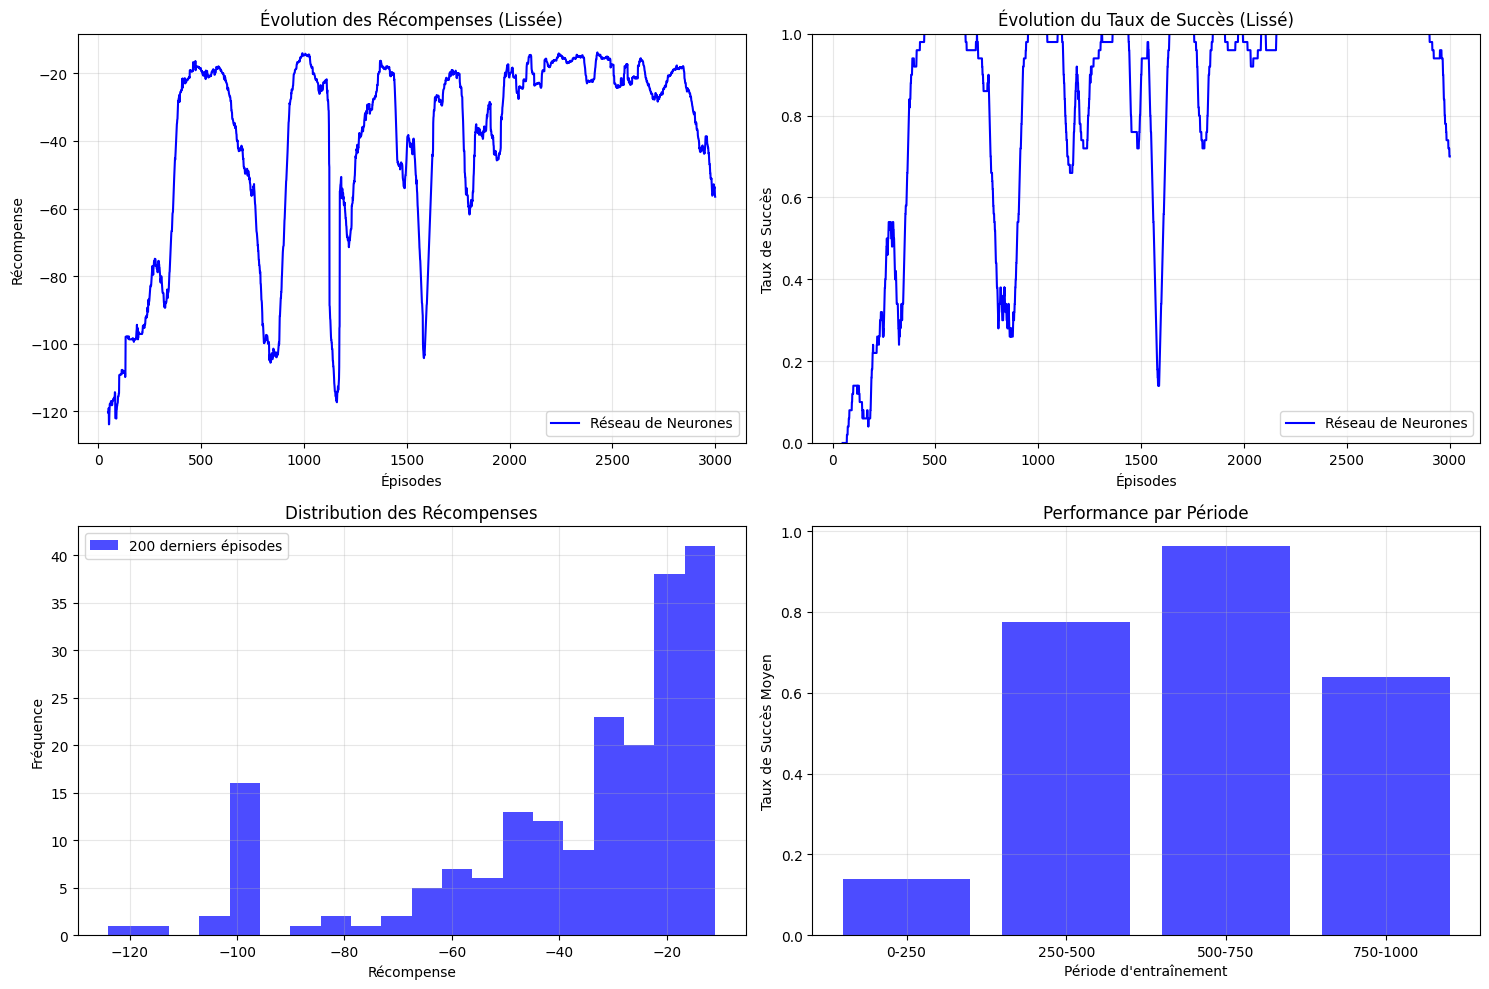

In [295]:
# Visualisation des performances
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Courbe de récompenses
window_smooth = 50
smoothed_rewards_nn = np.convolve(rewards_nn_fixed, np.ones(window_smooth)/window_smooth, mode='valid')
ax1.plot(range(window_smooth-1, len(rewards_nn_fixed)), smoothed_rewards_nn, 'b-', label='Réseau de Neurones')
ax1.set_xlabel('Épisodes')
ax1.set_ylabel('Récompense')
ax1.set_title('Évolution des Récompenses (Lissée)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Courbe de succès
smoothed_success_nn = np.convolve(successes_nn_fixed, np.ones(window_smooth)/window_smooth, mode='valid')
ax2.plot(range(window_smooth-1, len(successes_nn_fixed)), smoothed_success_nn, 'b-', label='Réseau de Neurones')
ax2.set_xlabel('Épisodes')
ax2.set_ylabel('Taux de Succès')
ax2.set_title('Évolution du Taux de Succès (Lissé)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

# Distribution des récompenses
ax3.hist(rewards_nn_fixed[-200:], bins=20, alpha=0.7, color='blue', label='200 derniers épisodes')
ax3.set_xlabel('Récompense')
ax3.set_ylabel('Fréquence')
ax3.set_title('Distribution des Récompenses')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Statistiques d'apprentissage
episodes_periods = [0, 250, 500, 750, 1000]
success_periods = []
reward_periods = []

for i in range(len(episodes_periods)-1):
    start = episodes_periods[i]
    end = episodes_periods[i+1]
    success_periods.append(np.mean(successes_nn_fixed[start:end]))
    reward_periods.append(np.mean(rewards_nn_fixed[start:end]))

x_periods = range(len(success_periods))
ax4.bar(x_periods, success_periods, alpha=0.7, color='blue')
ax4.set_xlabel('Période d\'entraînement')
ax4.set_ylabel('Taux de Succès Moyen')
ax4.set_title('Performance par Période')
ax4.set_xticks(x_periods)
ax4.set_xticklabels([f'{episodes_periods[i]}-{episodes_periods[i+1]}' for i in range(len(episodes_periods)-1)])
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Comparaison Q-Table vs Réseau de Neurones

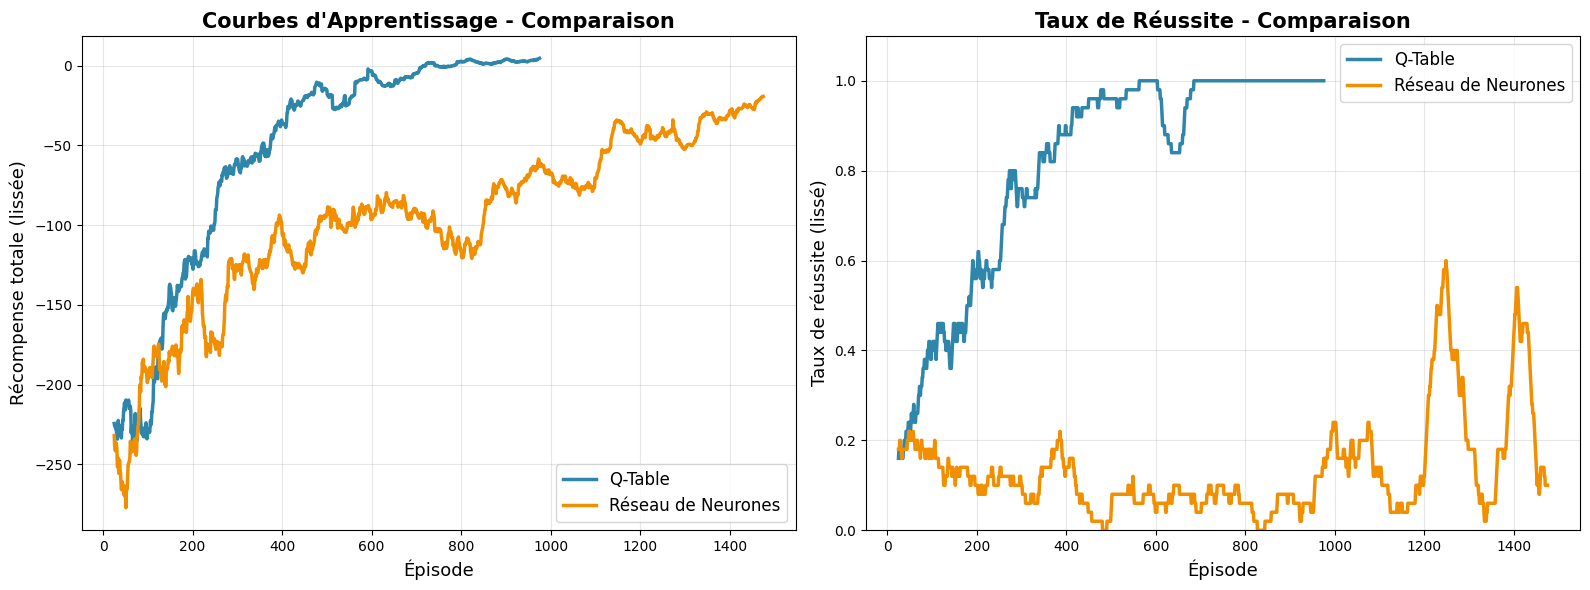

In [296]:
# Comparaison directe Q-Table vs Réseau de Neurones
plt.figure(figsize=(16, 6))

# Subplot 1: Récompenses lissées
plt.subplot(1, 2, 1)
window = 50

# Q-Table (données existantes)
smoothed_tabular = moving_average(rewards_fixed, window)
plt.plot(np.arange(len(smoothed_tabular)) + window // 2, smoothed_tabular, 
         label='Q-Table', linewidth=2.5, color='#2E86AB')

# Réseau de Neurones
smoothed_nn = moving_average(rewards_nn, window)
plt.plot(np.arange(len(smoothed_nn)) + window // 2, smoothed_nn, 
         label='Réseau de Neurones', linewidth=2.5, color='#F18F01')

plt.xlabel("Épisode", fontsize=13)
plt.ylabel("Récompense totale (lissée)", fontsize=13)
plt.title("Courbes d'Apprentissage - Comparaison", fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Subplot 2: Taux de réussite lissés
plt.subplot(1, 2, 2)
smoothed_success_tabular = moving_average(successes_fixed.astype(float), window)
smoothed_success_nn = moving_average(successes_nn.astype(float), window)

plt.plot(np.arange(len(smoothed_success_tabular)) + window // 2, smoothed_success_tabular, 
         label='Q-Table', linewidth=2.5, color='#2E86AB')
plt.plot(np.arange(len(smoothed_success_nn)) + window // 2, smoothed_success_nn, 
         label='Réseau de Neurones', linewidth=2.5, color='#F18F01')

plt.xlabel("Épisode", fontsize=13)
plt.ylabel("Taux de réussite (lissé)", fontsize=13)
plt.title("Taux de Réussite - Comparaison", fontsize=15, fontweight='bold')
plt.ylim(0, 1.1)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\Rog strix Scar\AppData\Local\Temp\ipykernel_7252\597903681.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_comp, labels=['Q-Table', 'Réseau de\nNeurones'],


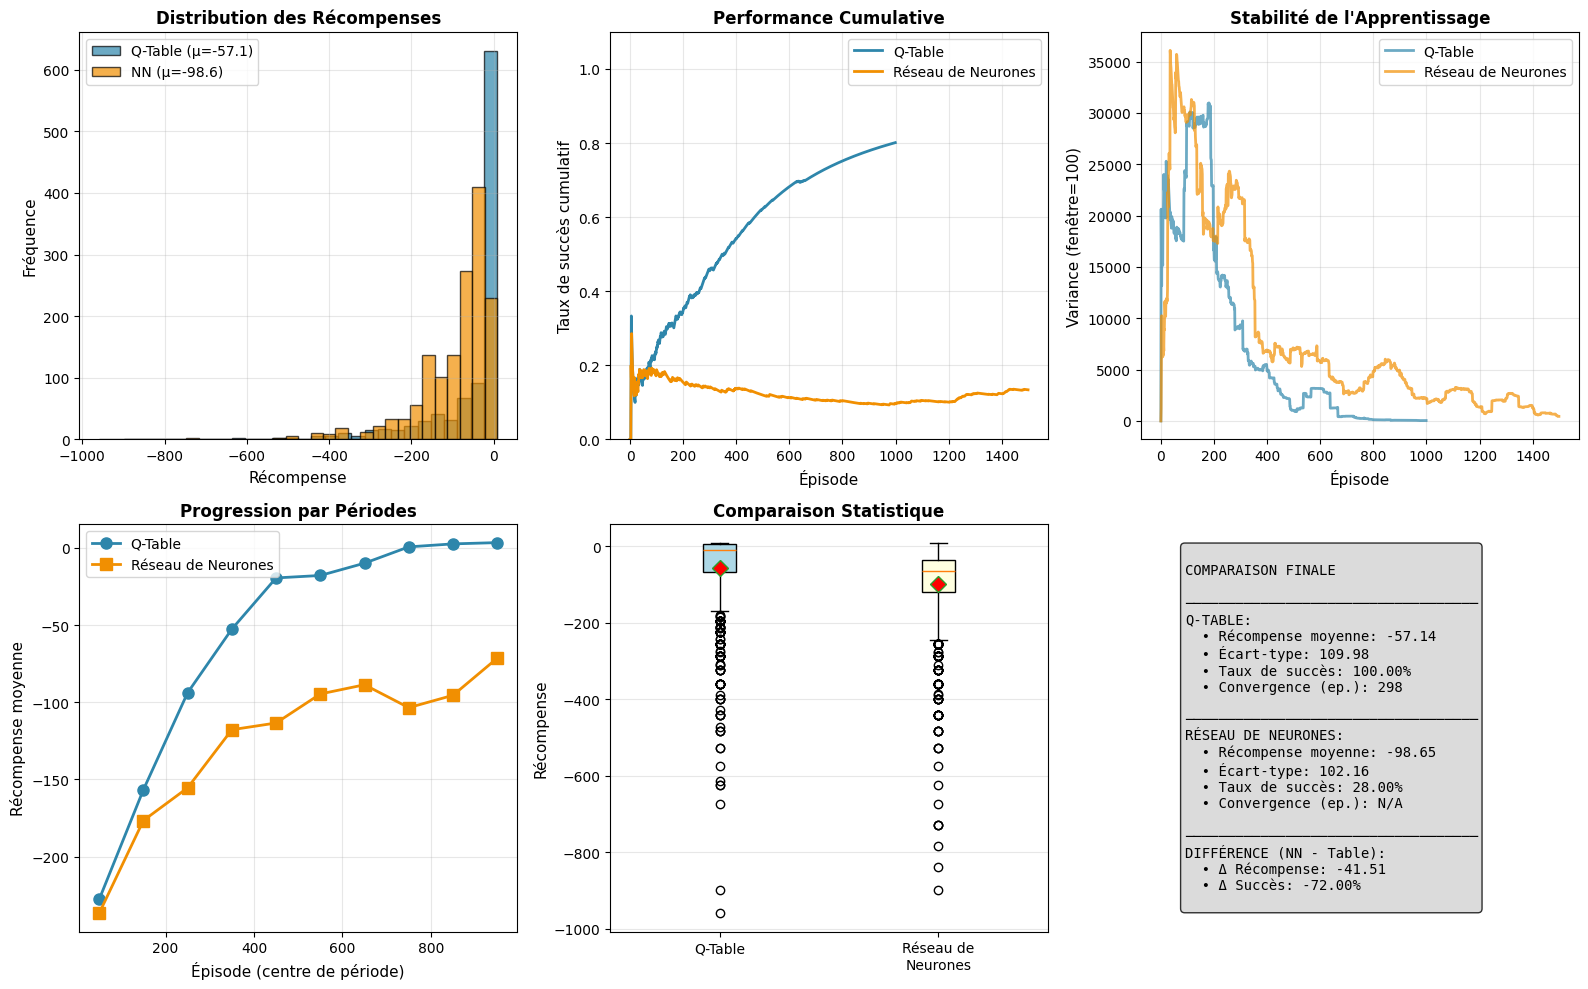

In [297]:
# Analyse comparative détaillée
plt.figure(figsize=(16, 10))

# 1. Distribution des récompenses
plt.subplot(2, 3, 1)
plt.hist(rewards_fixed, bins=30, alpha=0.7, color='#2E86AB', 
         label=f'Q-Table (μ={np.mean(rewards_fixed):.1f})', edgecolor='black')
plt.hist(rewards_nn, bins=30, alpha=0.7, color='#F18F01', 
         label=f'NN (μ={np.mean(rewards_nn):.1f})', edgecolor='black')
plt.xlabel("Récompense", fontsize=11)
plt.ylabel("Fréquence", fontsize=11)
plt.title("Distribution des Récompenses", fontsize=12, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# 2. Performance cumulative
plt.subplot(2, 3, 2)
cumulative_tabular = np.cumsum(successes_fixed) / (np.arange(len(successes_fixed)) + 1)
cumulative_nn = np.cumsum(successes_nn) / (np.arange(len(successes_nn)) + 1)

plt.plot(cumulative_tabular, label='Q-Table', linewidth=2, color='#2E86AB')
plt.plot(cumulative_nn, label='Réseau de Neurones', linewidth=2, color='#F18F01')
plt.xlabel("Épisode", fontsize=11)
plt.ylabel("Taux de succès cumulatif", fontsize=11)
plt.title("Performance Cumulative", fontsize=12, fontweight='bold')
plt.ylim(0, 1.1)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# 3. Variance mobile (stabilité)
plt.subplot(2, 3, 3)
window_var = 100
var_tabular = [np.var(rewards_fixed[max(0, i-window_var):i+1]) 
               for i in range(len(rewards_fixed))]
var_nn = [np.var(rewards_nn[max(0, i-window_var):i+1]) 
          for i in range(len(rewards_nn))]

plt.plot(var_tabular, label='Q-Table', linewidth=2, color='#2E86AB', alpha=0.7)
plt.plot(var_nn, label='Réseau de Neurones', linewidth=2, color='#F18F01', alpha=0.7)
plt.xlabel("Épisode", fontsize=11)
plt.ylabel("Variance (fenêtre=100)", fontsize=11)
plt.title("Stabilité de l'Apprentissage", fontsize=12, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# 4. Performance par périodes
plt.subplot(2, 3, 4)
period_size = 100
num_periods = min(len(rewards_fixed), len(rewards_nn)) // period_size
mean_tabular_periods = [np.mean(rewards_fixed[i*period_size:(i+1)*period_size]) 
                        for i in range(num_periods)]
mean_nn_periods = [np.mean(rewards_nn[i*period_size:(i+1)*period_size]) 
                   for i in range(num_periods)]

x_periods = np.arange(num_periods) * period_size + period_size // 2
plt.plot(x_periods, mean_tabular_periods, marker='o', markersize=8, 
         linewidth=2, color='#2E86AB', label='Q-Table')
plt.plot(x_periods, mean_nn_periods, marker='s', markersize=8, 
         linewidth=2, color='#F18F01', label='Réseau de Neurones')
plt.xlabel("Épisode (centre de période)", fontsize=11)
plt.ylabel("Récompense moyenne", fontsize=11)
plt.title("Progression par Périodes", fontsize=12, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# 5. Box plot comparatif
plt.subplot(2, 3, 5)
data_comp = [rewards_fixed, rewards_nn]
bp = plt.boxplot(data_comp, labels=['Q-Table', 'Réseau de\nNeurones'], 
                 patch_artist=True, showmeans=True,
                 meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
colors_comp = ['lightblue', 'lightyellow']
for patch, color in zip(bp['boxes'], colors_comp):
    patch.set_facecolor(color)
plt.ylabel("Récompense", fontsize=11)
plt.title("Comparaison Statistique", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# 6. Statistiques finales
plt.subplot(2, 3, 6)
plt.axis('off')

# Calculer les statistiques
stats_tabular = {
    'mean': np.mean(rewards_fixed),
    'std': np.std(rewards_fixed),
    'success_rate': np.mean(successes_fixed[-100:]),
    'max_reward': np.max(rewards_fixed),
    'convergence': None
}

stats_nn = {
    'mean': np.mean(rewards_nn),
    'std': np.std(rewards_nn),
    'success_rate': np.mean(successes_nn[-100:]),
    'max_reward': np.max(rewards_nn),
    'convergence': None
}

# Trouver l'épisode de convergence (80% de succès sur 50 épisodes)
for i in range(50, len(successes_fixed)):
    if np.mean(successes_fixed[i-50:i]) >= 0.8 and stats_tabular['convergence'] is None:
        stats_tabular['convergence'] = i
    if np.mean(successes_nn[i-50:i]) >= 0.8 and stats_nn['convergence'] is None:
        stats_nn['convergence'] = i

conv_tab = stats_tabular['convergence'] if stats_tabular['convergence'] else 'N/A'
conv_nn = stats_nn['convergence'] if stats_nn['convergence'] else 'N/A'

comparison_text = f"""
COMPARAISON FINALE

{'─'*35}
Q-TABLE:
  • Récompense moyenne: {stats_tabular['mean']:.2f}
  • Écart-type: {stats_tabular['std']:.2f}
  • Taux de succès: {stats_tabular['success_rate']:.2%}
  • Convergence (ep.): {conv_tab}

{'─'*35}
RÉSEAU DE NEURONES:
  • Récompense moyenne: {stats_nn['mean']:.2f}
  • Écart-type: {stats_nn['std']:.2f}
  • Taux de succès: {stats_nn['success_rate']:.2%}
  • Convergence (ep.): {conv_nn}

{'─'*35}
DIFFÉRENCE (NN - Table):
  • Δ Récompense: {stats_nn['mean'] - stats_tabular['mean']:+.2f}
  • Δ Succès: {stats_nn['success_rate'] - stats_tabular['success_rate']:+.2%}
"""

plt.text(0.1, 0.5, comparison_text, fontsize=10, family='monospace', 
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()